# Выбор локации для скважины

Для добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, а также проанализировать возможную прибыль и риски техникой Bootstrap.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:

- для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые)  
- при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки  
- бюджет на разработку скважин в регионе — 10 млрд рублей  
- при нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей  
- после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью  

Входные данные:

Данные геологоразведки трёх регионов находятся в файлах: geo_data_0.csv, geo_data_1.csv, geo_data_2.csv.  
id - уникальный идентификатор скважины;  
f0, f1, f2 - три признака точек (неважно, что они означают, но сами признаки значимы);  
product - объём запасов в скважине (тыс. баррелей).  

## Загрузка и подготовка данных

### Загрузка данных

Импортируем необходимые модули для работы:

In [1]:
# Установка пакета
!pip install phik -q

# Стандартная библиотека
from math import sqrt
from scipy import stats as st

# Работа с данными и визуализация
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Препроцессинг и модели sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Метрики
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Дополнительные пакеты
import phik


Зададим переменные RANDOM_STATE и TEST_SIZE:

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Загрузим данные проверим общую информацию по датафреймам:

In [3]:
try:
    df_geo_0 = pd.read_csv('geo_data_0.csv')
    df_geo_1 = pd.read_csv('geo_data_1.csv')
    df_geo_2 = pd.read_csv('geo_data_2.csv')
except:
    df_geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
df_geo_0.head()

id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

In [5]:
df_geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
df_geo_1.head()

id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

In [7]:
df_geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
df_geo_2.head()

id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746

In [9]:
df_geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


#### Выводы по загрузке данных

В трех загруженных файлах по 100000 строк и 5 колонок. Типы данных в колонках корректные, пропусков нет.

### Предобработка данных

Проверим данные на полные дубликаты и на дубликаты в колонке 'id':

In [10]:
# Проверка на полные дубликаты
for df in [df_geo_0, df_geo_1, df_geo_2]:
    display(df.duplicated().sum())

np.int64(0)

np.int64(0)

np.int64(0)

In [11]:
# Проверка на дубликаты в колонке id
for df in [df_geo_0, df_geo_1, df_geo_2]:
    display(df['id'].duplicated().sum())

np.int64(10)

np.int64(4)

np.int64(4)

In [12]:
#Удалим дубликаты
df_geo_0.drop_duplicates(subset='id', inplace=True)
df_geo_1.drop_duplicates(subset='id', inplace=True)
df_geo_2.drop_duplicates(subset='id', inplace=True)

Сделаем 'id' индексом:

In [13]:
df_geo_0 = df_geo_0.set_index('id')
df_geo_1 = df_geo_1.set_index('id')
df_geo_2 = df_geo_2.set_index('id')

#### Выводы по предобрботке данных

- выполнена проверка на полные дубликаты (дубликатов не обнаружено)  
- удалены дубликаты в колонке 'id' (df_geo_0 - 10 дубликатов), (df_geo_1 - 4 дубликата), (df_geo_2 - 4 дубликата)

### Исследовательский анализ

#### Функция для вывода статистики и графиков

Напишем функцию, которая будет выводить статистику и необходимую графиу по каждой площади:

In [14]:
# функция для вывода статистики, построения гистограммы и боксплот
def stat_hist_boxplot_builder(df, columns, df_title):
    print(f'Статистика по датафрейму {df_title}')
    display(df.describe().T)
    
    for column in df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        #Гистограмма 
        sns.histplot(
            data=df,
            x=column,
            bins=30,          
            ax=axes[0],       
            color='royalblue'
        )
        axes[0].set_title(f'Гистограмма "{column}" ({df_title})')
        axes[0].set_xlabel(f'{column}')
        axes[0].set_ylabel('Частота')

        #Боксплот
        sns.boxplot(
        data=df,
        y=column,
        ax=axes[1],
        color='lightgreen',
        width=0.4
        )

        axes[1].set_title(f'Боксплот "{column}" ({df_title})')
        axes[1].set_ylabel(f'{column}')
        axes[1].set_xlabel('')

        plt.tight_layout()
        plt.show()

#### Исследовательский анализ df_geo_0

Выведем статистику и графики по площади geo_0:

Статистика по датафрейму df_geo_0


count       mean        std        min        25%        50%  \
f0       99990.0   0.500454   0.871844  -1.408605  -0.072572   0.502405   
f1       99990.0   0.250141   0.504430  -0.848218  -0.200877   0.250252   
f2       99990.0   2.502629   3.248149 -12.088328   0.287784   2.515969   
product  99990.0  92.499684  44.288304   0.000000  56.497069  91.847928   

                75%         max  
f0         1.073626    2.362331  
f1         0.700640    1.343769  
f2         4.715035   16.003790  
product  128.563699  185.364347

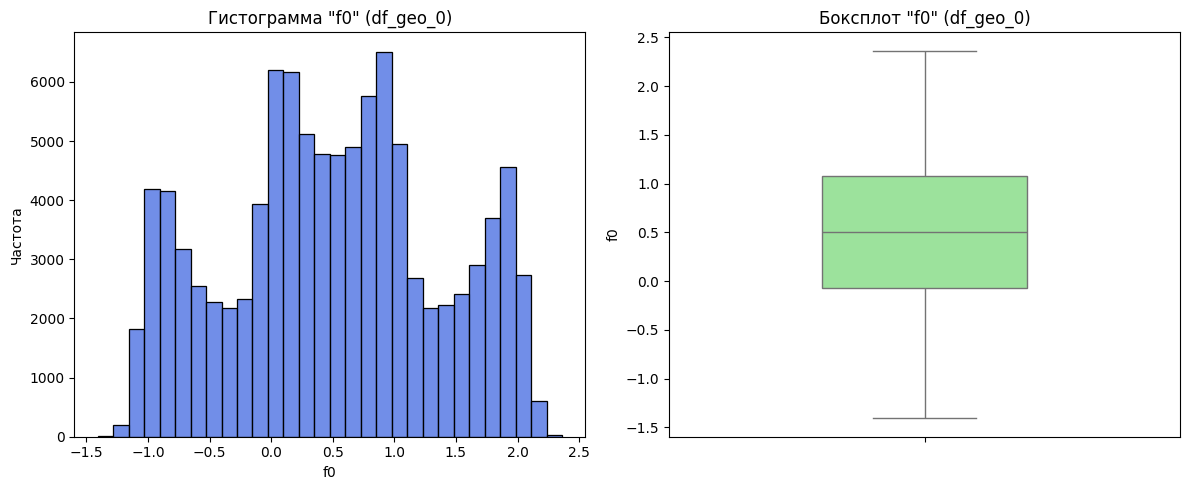

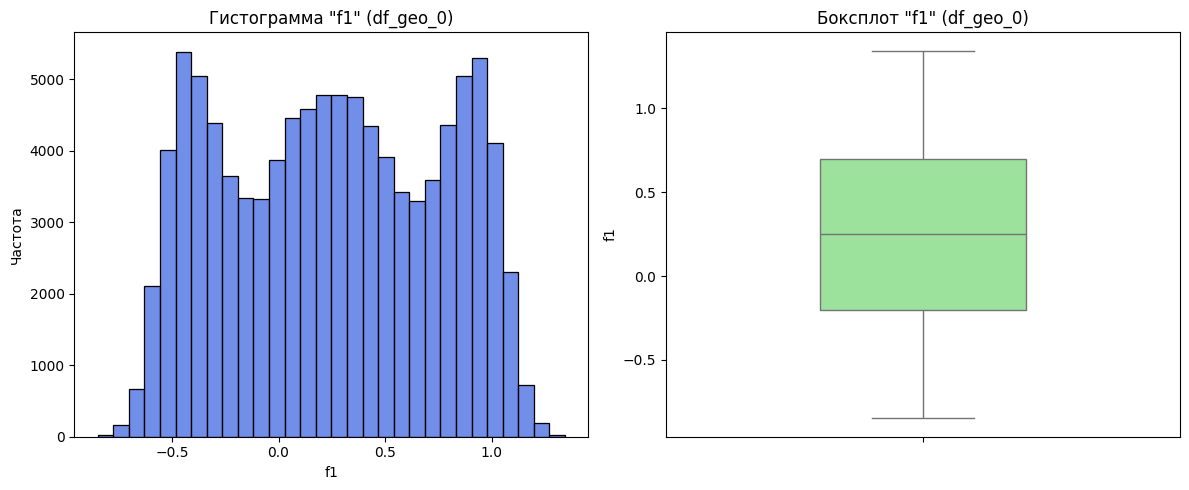

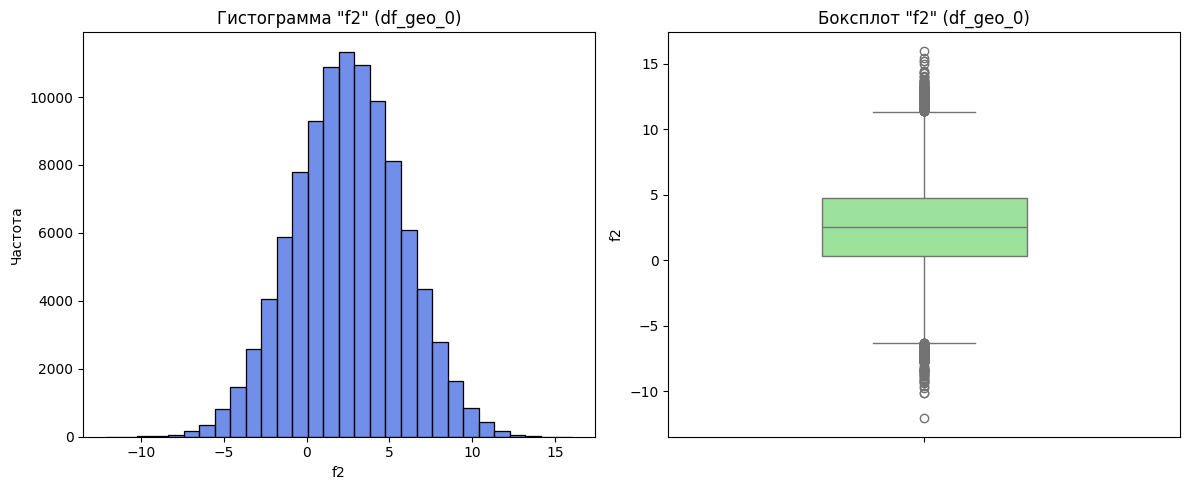

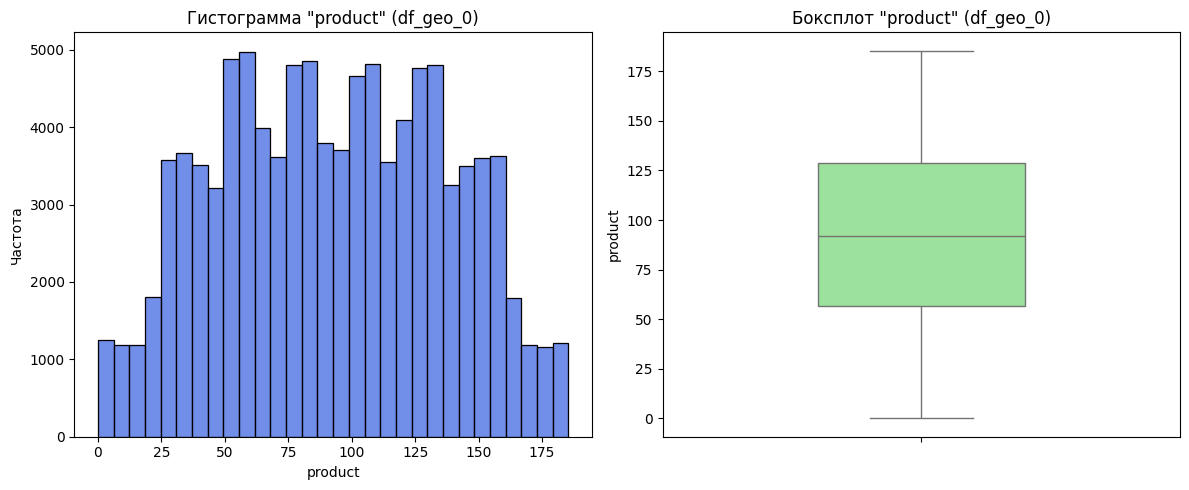

In [15]:
#df_geo_0
stat_hist_boxplot_builder(df_geo_0, df_geo_0.columns, 'df_geo_0')

Из всех признаков только f2 имеет нормальное распределение. Однако все признаки имеют симметричные распределения

#### Исследовательский анализ df_geo_1

Выведем статистику и графики по площади geo_1:

Статистика по датафрейму df_geo_1


count       mean        std        min        25%        50%  \
f0       99996.0   1.141209   8.965815 -31.609576  -6.298551   1.153055   
f1       99996.0  -4.796608   5.119906 -26.358598  -8.267985  -4.813172   
f2       99996.0   2.494501   1.703579  -0.018144   1.000021   2.011475   
product  99996.0  68.823916  45.944663   0.000000  26.953261  57.085625   

                75%         max  
f0         8.620964   29.421755  
f1        -1.332816   18.734063  
f2         3.999904    5.019721  
product  107.813044  137.945408

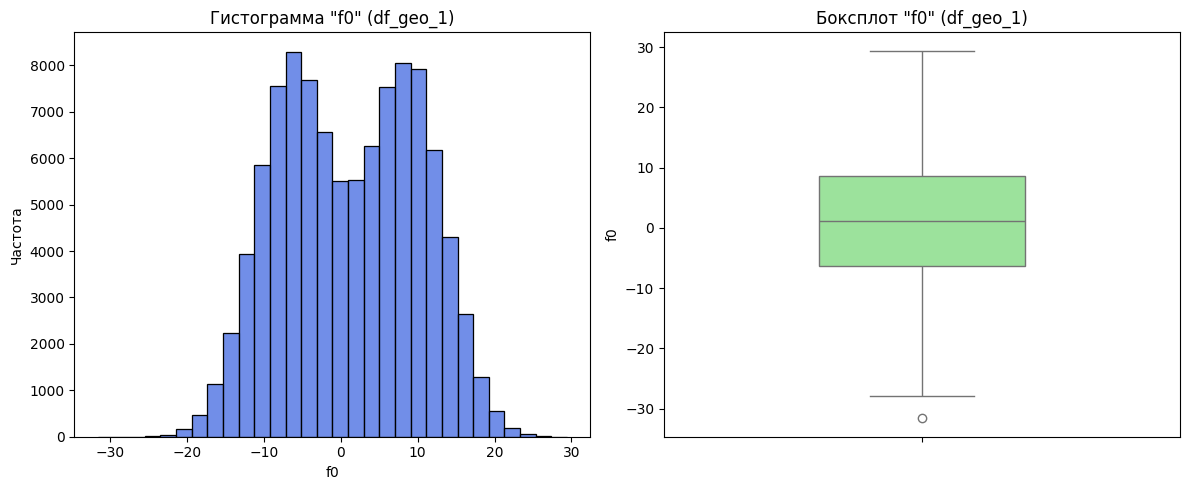

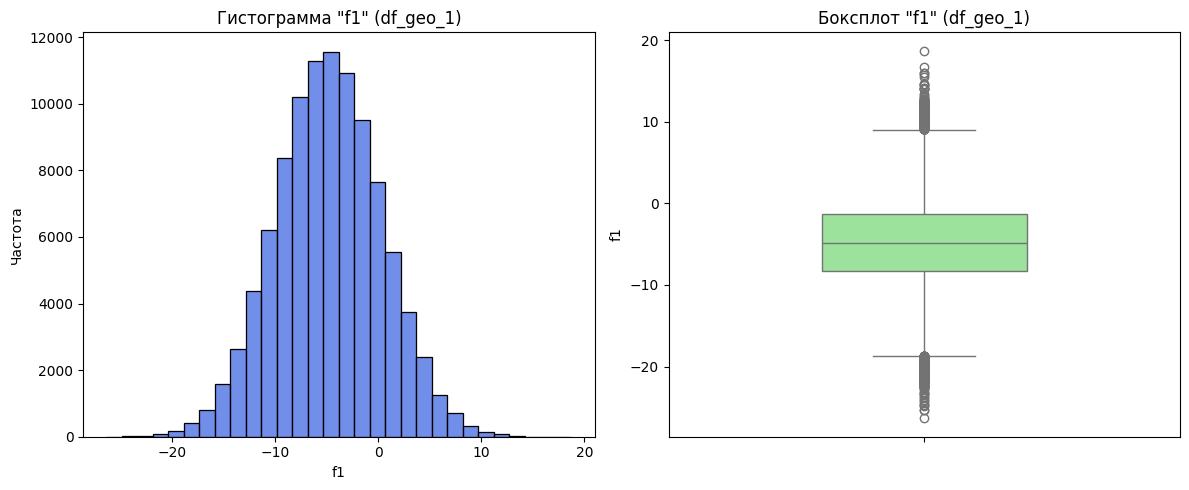

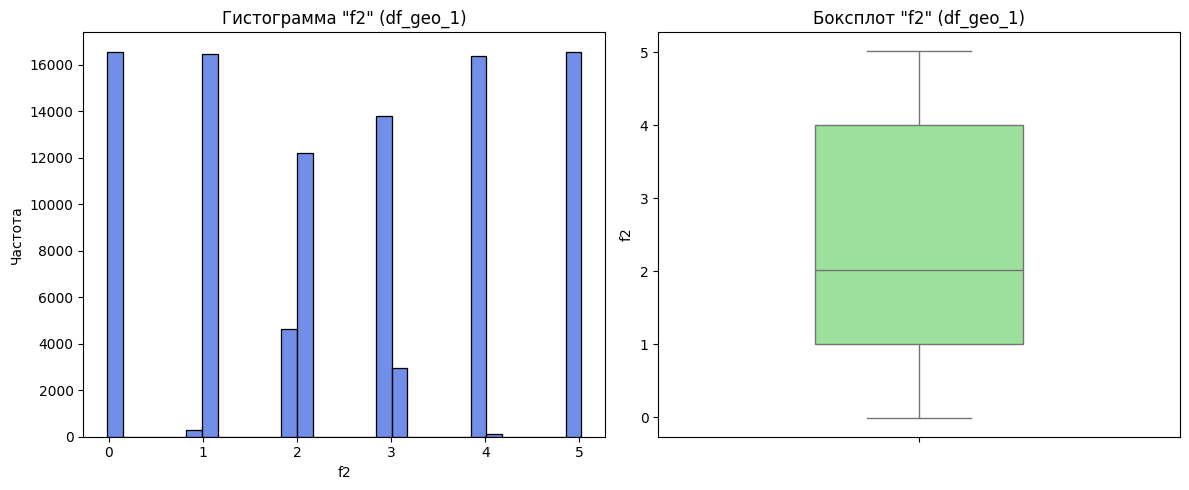

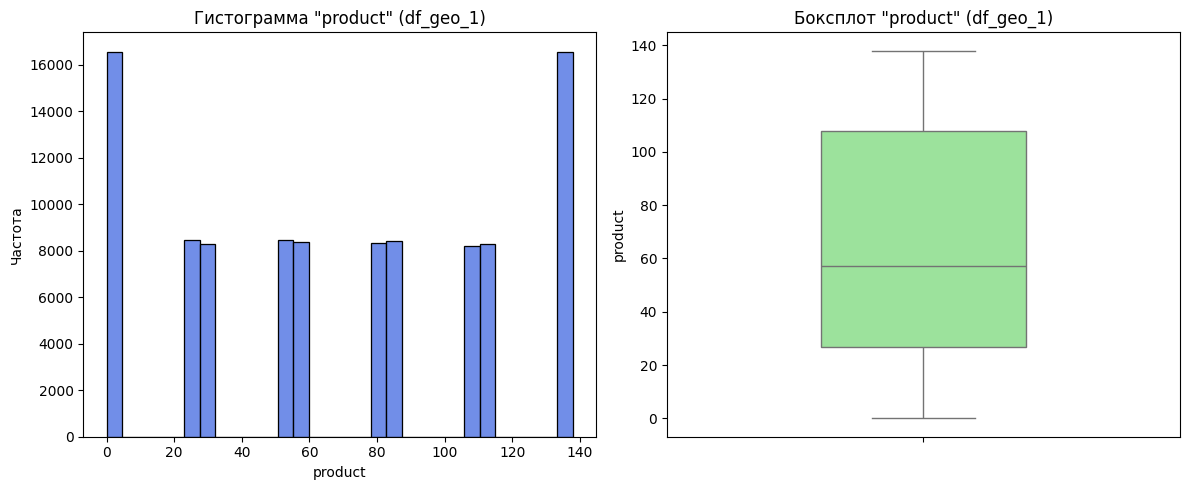

In [16]:
#df_geo_1
stat_hist_boxplot_builder(df_geo_1, df_geo_1.columns, 'df_geo_1')

- f0 имеет симметричное распределение 
- f1 имеет нормальное распределение
- значения f2 и product разделены на сегменты 

#### Исследовательский анализ df_geo_2

Выведем статистику и графики по площади geo_2:

Статистика по датафрейму df_geo_2


count       mean        std        min        25%        50%  \
f0       99996.0   0.002002   1.732052  -8.760004  -1.162328   0.009424   
f1       99996.0  -0.002159   1.730397  -7.084020  -1.174841  -0.009661   
f2       99996.0   2.495084   3.473482 -11.970335   0.130269   2.484236   
product  99996.0  94.998342  44.749573   0.000000  59.450028  94.925026   

                75%         max  
f0         1.158477    7.238262  
f1         1.163523    7.844801  
f2         4.858720   16.739402  
product  130.586815  190.029838

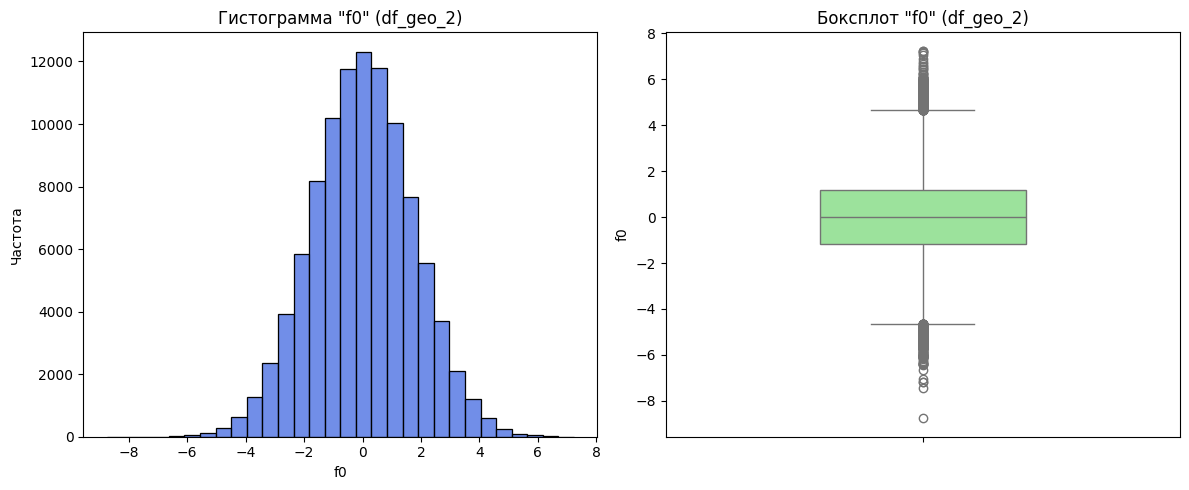

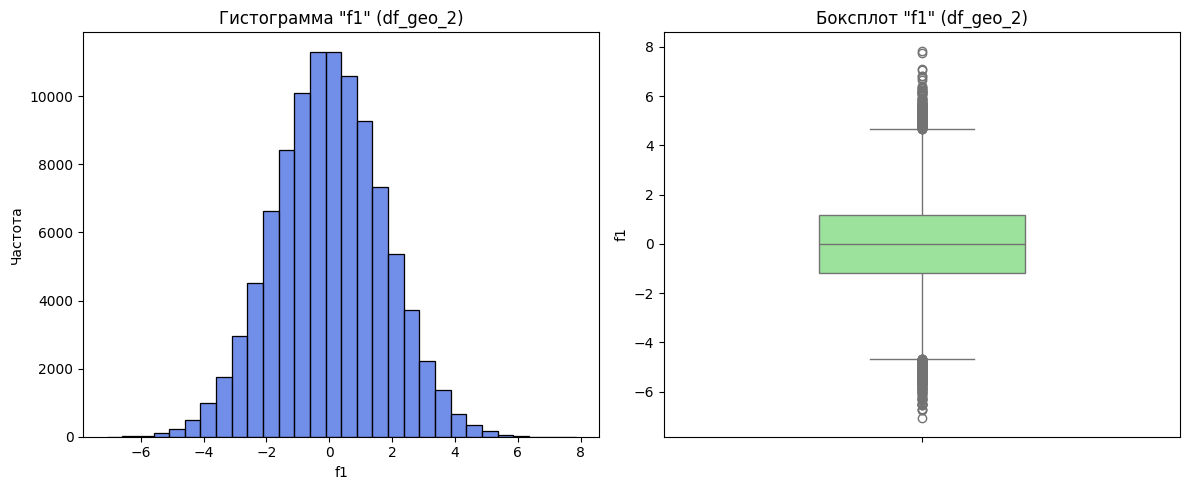

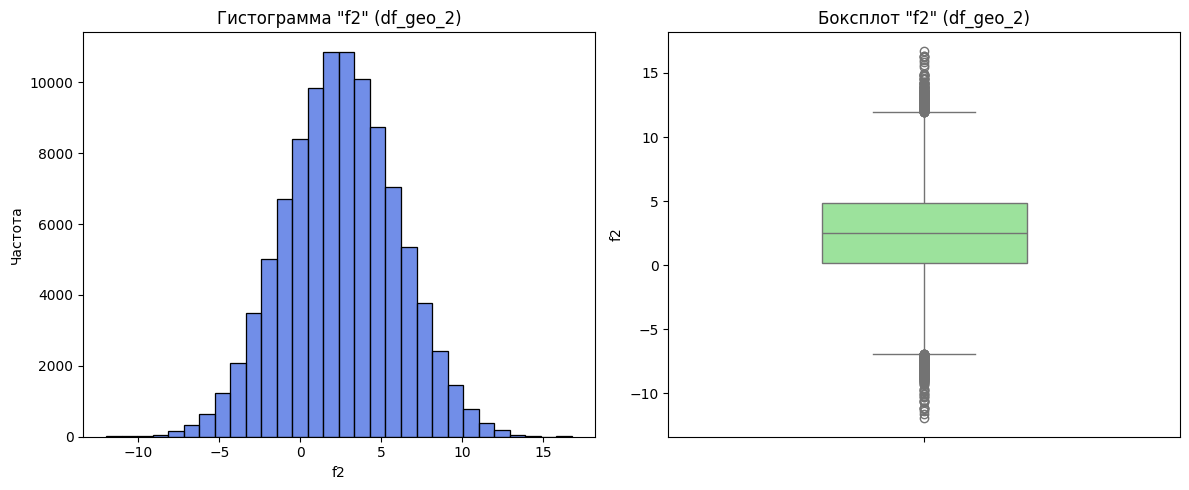

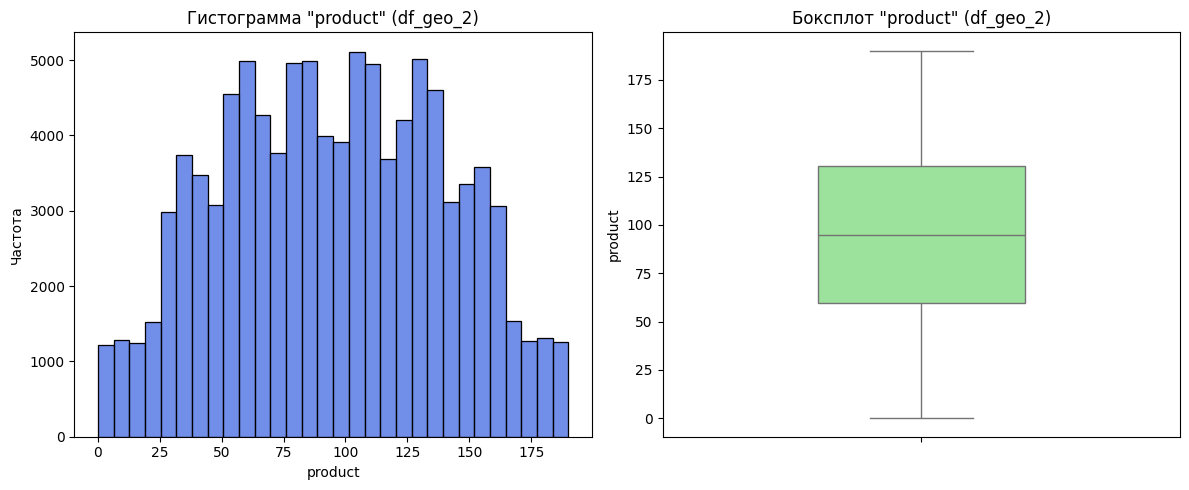

In [17]:
#df_geo_2
stat_hist_boxplot_builder(df_geo_2, df_geo_2.columns, 'df_geo_2')

- f0, f1, f2 имеют нормальное распределение
- product имеет симметричное распределение

#### Выводы по исследовательскому анализу 

**df_geo_0**

- Средние значения признаков f0, f1, f2, product равны, соответственно, 0.5, 0.25, 2.5, 92.5.  
- Из всех признаков только f2 имеет нормальное распределение. Однако все признаки имеют симметричные распределения.

**df_geo_1**

- Средние значения признаков f0, f1, f2, product равны, соответственно, 1.1, -4.8, 2.5, 68.8.  
- f0 имеет симметричное распределение   
- f1 имеет нормальное распределение  
- значения f2 и product разделены на сегменты  

**df_geo_2**

- Средние значения признаков f0, f1, f2, product равны, соответственно, 0.002, -0.002, 2.5, 95.    
- f0, f1, f2 имеют нормальное распределение  
- product имеет симметричное распределение  

### Корреляционный анализ

#### Вспомогательная функция для корреляционного анализа

Напишем вспомогательную функцию, выводящую на экран попарные диаграммы рассеяния и корреляционные матрицы Phik и Пирсона (дополнительно):

In [18]:
def corr_analysis(df, int_cols, df_title):
    sns.pairplot(df,
            kind="scatter",
            diag_kind="kde",
            plot_kws={'alpha': 0.4, 's': 10},
            height=3.5,
            )
    plt.suptitle(f"Попарные диаграммы рассеяния для {df_title}", fontsize=16, y=1)
    plt.show()
    
    # Построение двух тепловых карт рядом
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Pearson
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', ax=axes[0], fmt=".2f")
    axes[0].set_title("Корреляция Пирсона")

    # Phik
    sns.heatmap(df.phik_matrix(interval_cols=int_cols), 
                annot=True, cmap='YlGnBu', ax=axes[1], fmt=".2f")
    axes[1].set_title("Phik-корреляция")

    plt.suptitle(f"Корреляционные матрицы для {df_title}", fontsize=18, y=1)
    plt.tight_layout()
    plt.show()

#### Корреляционный анализ df_geo_0

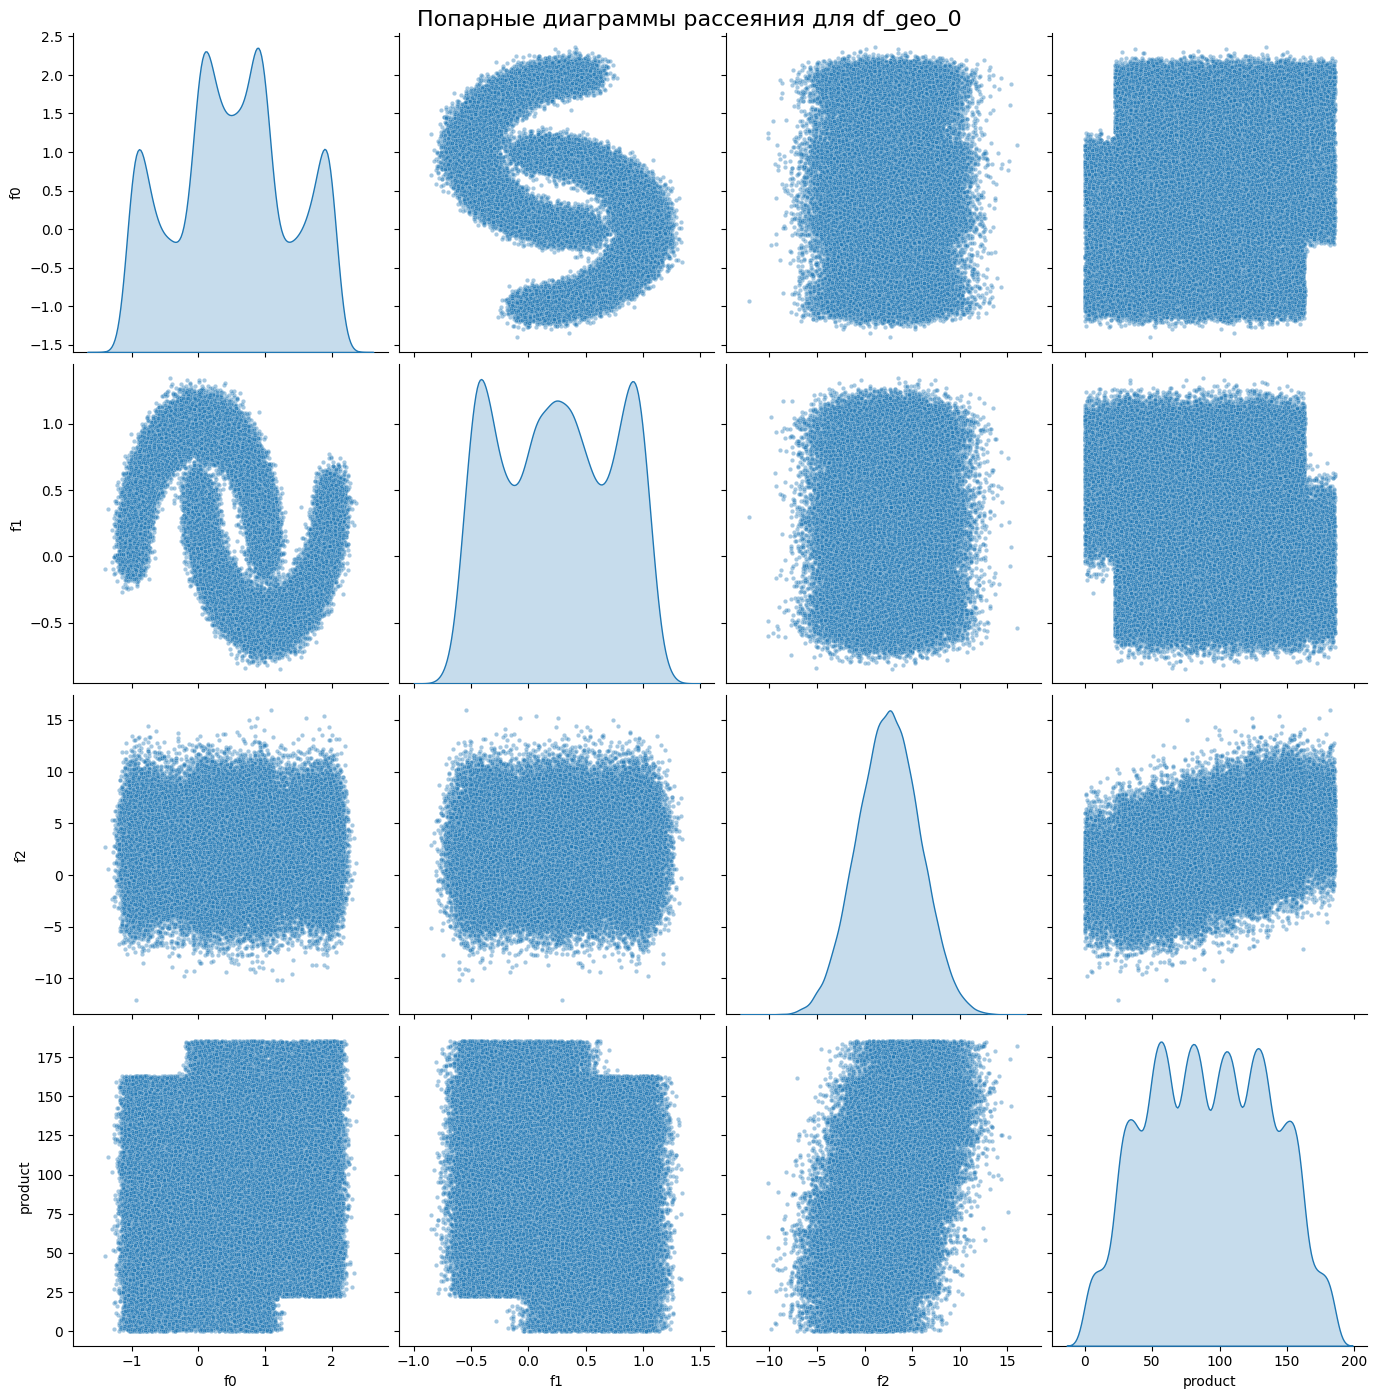

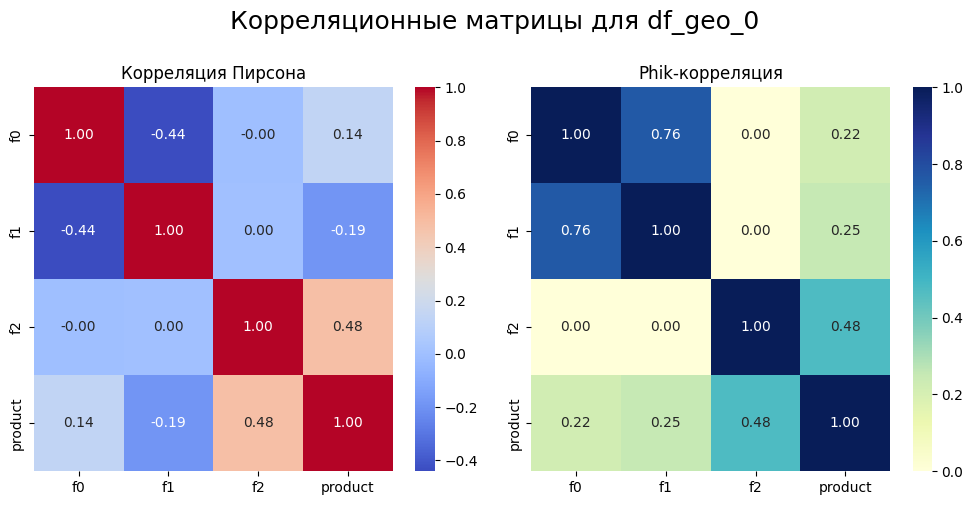

In [19]:
#df_geo_0
int_cols = ['f0','f1','f2','product']
corr_analysis(df_geo_0, int_cols, "df_geo_0")

- мультиколлинеарность во входных признаках отсутствует
- наблюдается зависимость между признаками f1 и f0 (к.кор. phik равен 0.76)
- целевой признак product имеет умеренную зависимость с f2 и слабую зависимость с f0 и f1

#### Корреляционный анализ df_geo_1

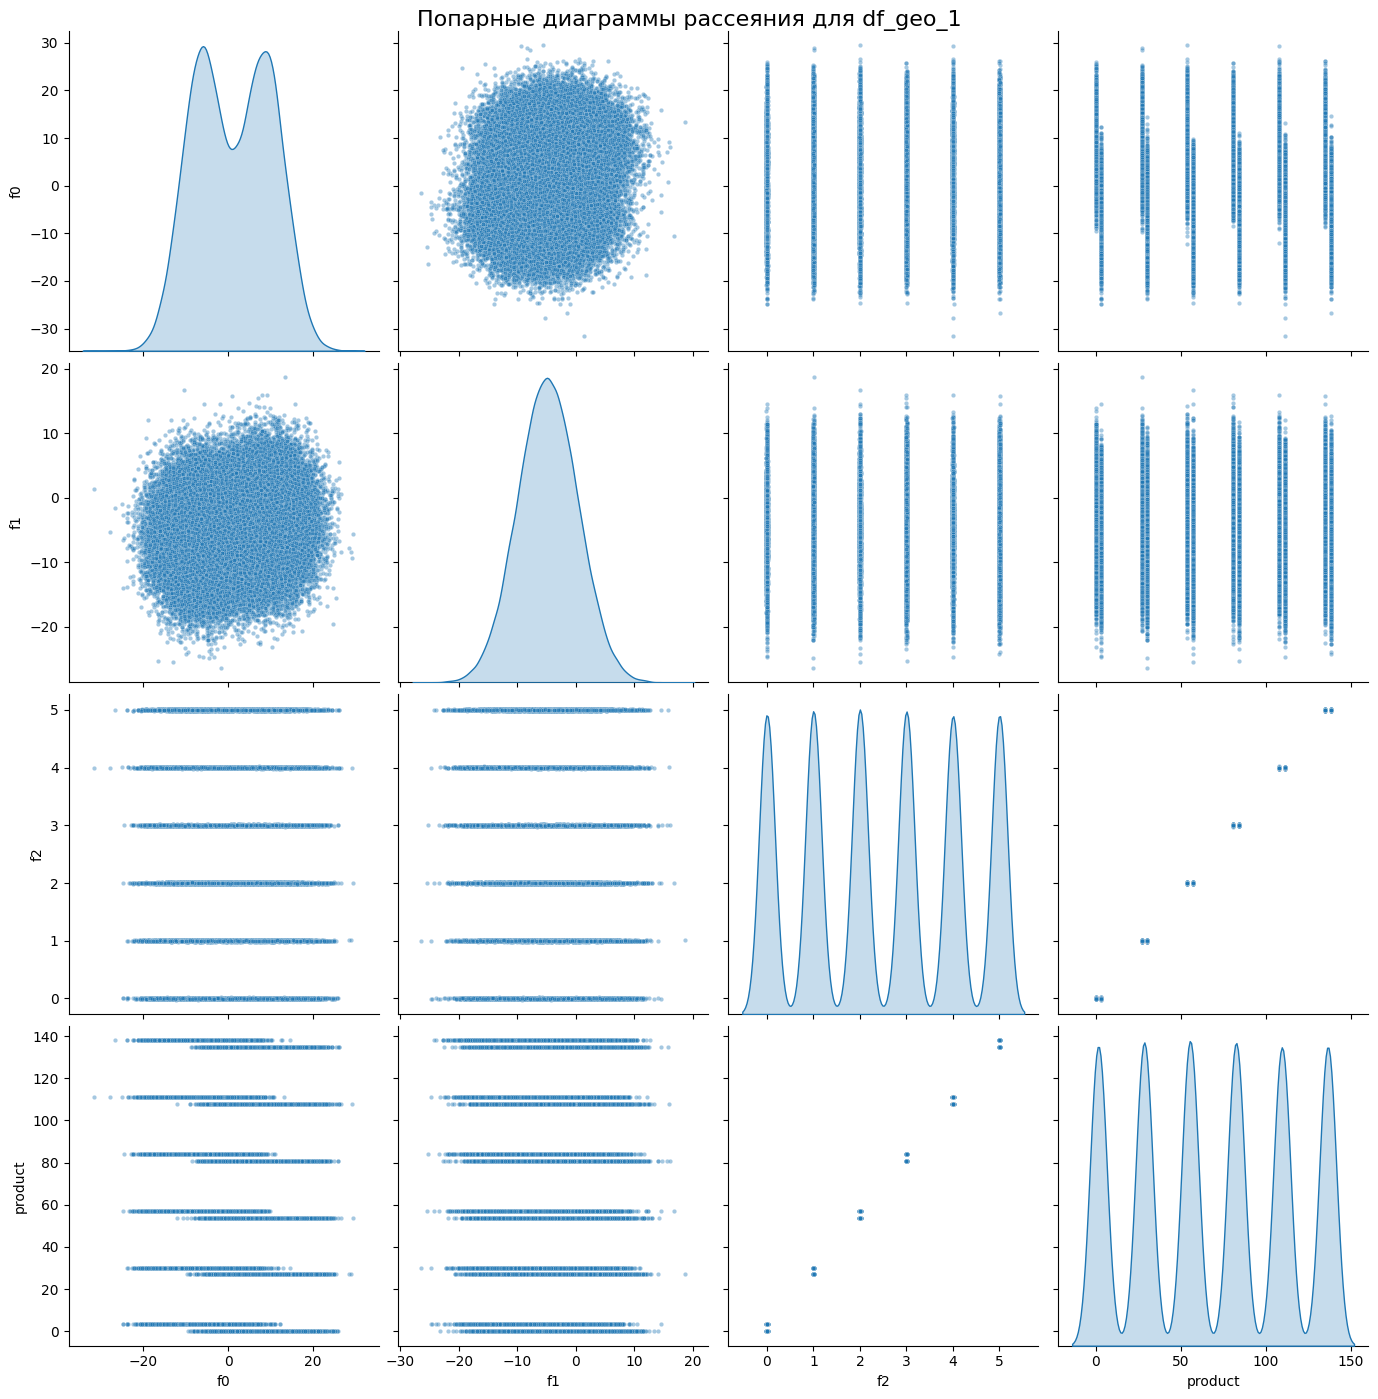

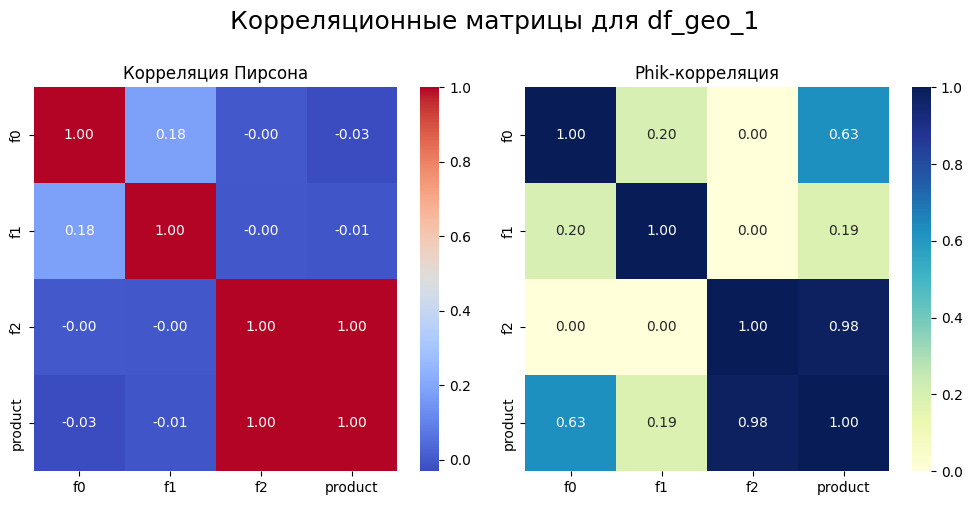

In [20]:
#df_geo_1
int_cols = ['f0','f1','f2', 'product']
corr_analysis(df_geo_1, int_cols, "df_geo_1")

- мультиколлинеарность во входных признаках отсутствует
- наблюдается слабая зависимость между признаками f1 и f0 (к.кор. phik равен 0.2)
- целевой признак product имеет очень высокую зависимость с f2 (к.кор. phik равен 0.98)
- к.кор. phik между целевым признаком product и входными признаками f0 и f1 равны, соответственно, 0.63 и 0.19, но к.кор Пирсона равны, соответственно, -0.03 и -0.01, что говорит о том, что между признаками есть связь, но нелинейная

#### Корреляционный анализ df_geo_2

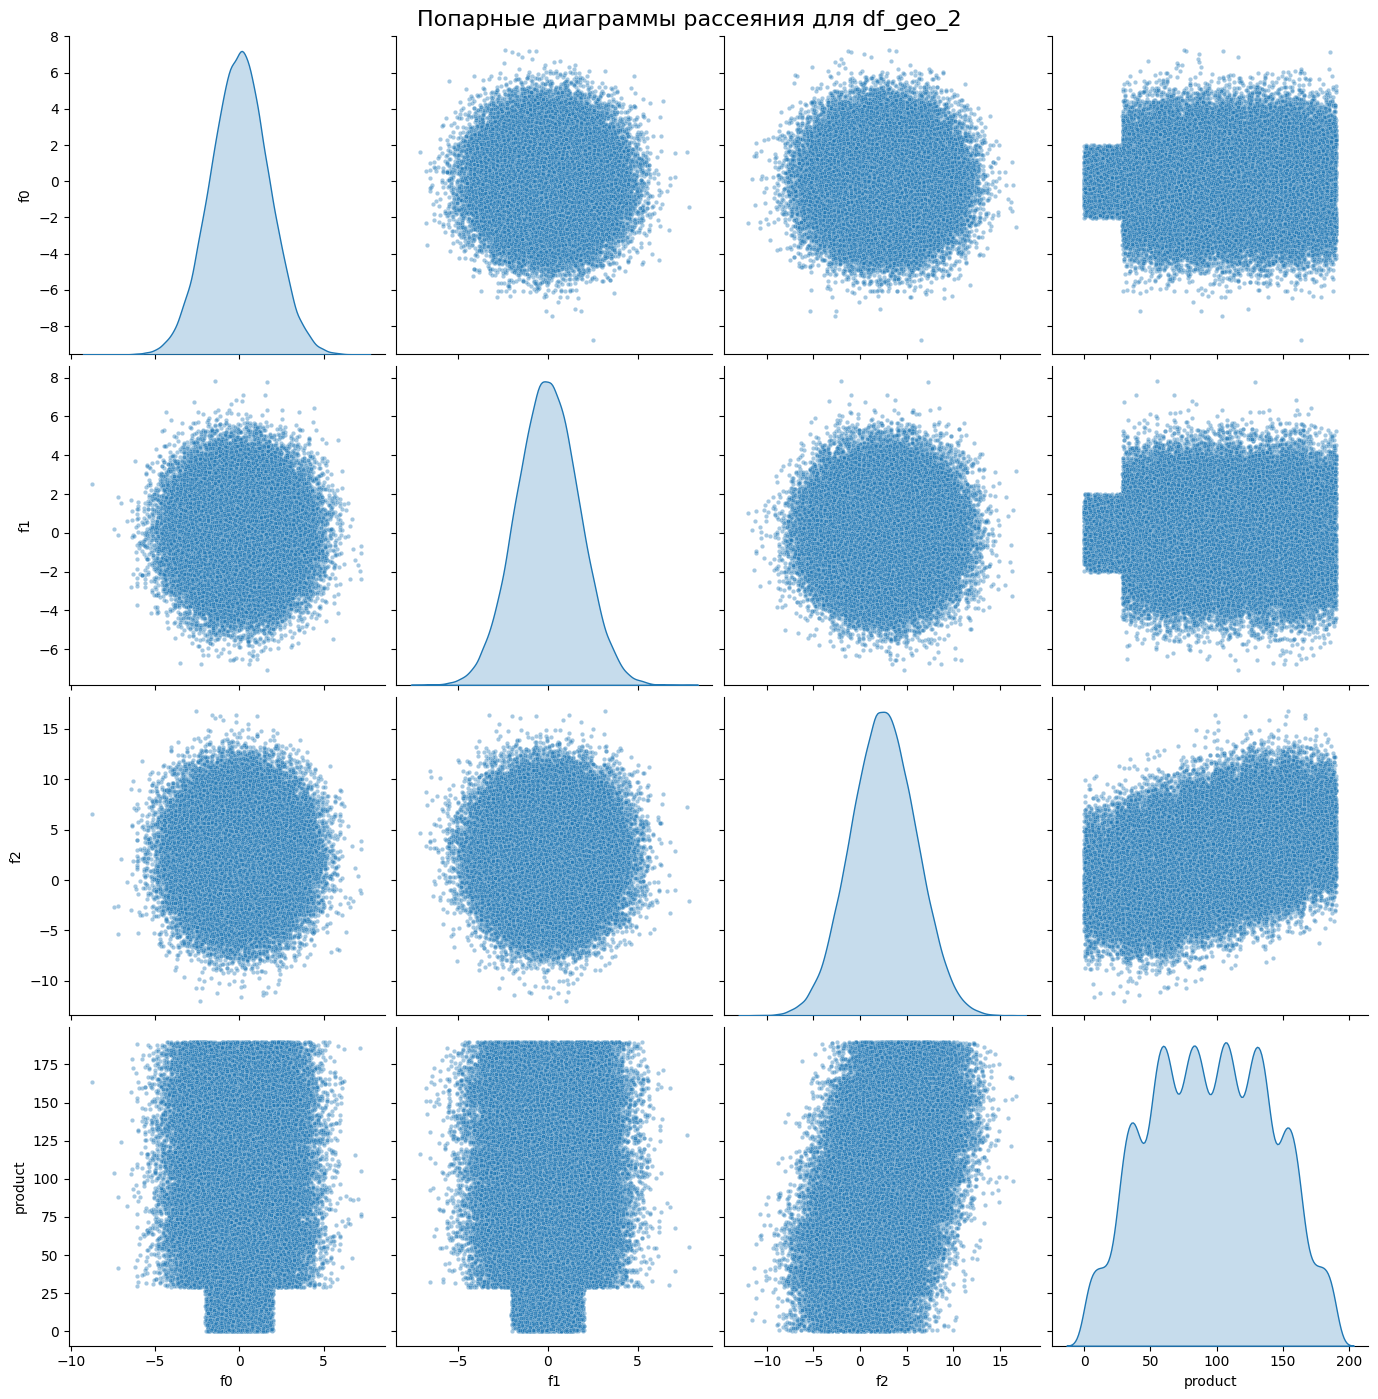

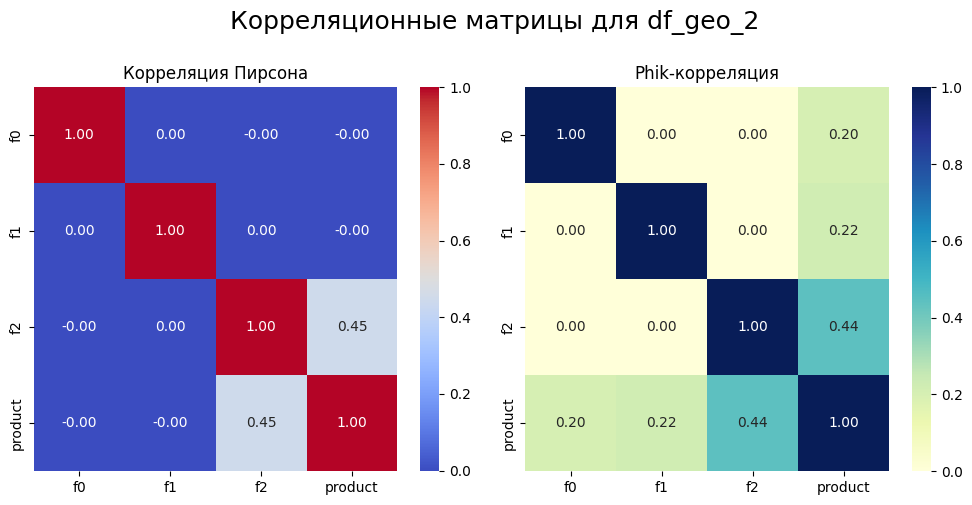

In [21]:
#df_geo_2
int_cols = ['f0','f1','f2', 'product']
corr_analysis(df_geo_2, int_cols, "df_geo_2")

- мультиколлинеарность во входных признаках отсутствует
- входные признаки независимы между сообой
- целевой признак product имеет умеренную зависимость с f2 (к.кор. phik равен 0.44)
- к.кор. phik между целевым признаком product и входными признаками f0 и f1 равны, соответственно, 0.2 и 0.22, но к.кор Пирсона равны 0, что говорит о том, что между product и входными признаками f0 и f1 нет линейной зависимости.

#### Выводы по корреляционному анализу

**df_geo_0**

- мультиколлинеарность во входных признаках отсутствует
- наблюдается зависимость между признаками f1 и f0 (к.кор. phik равен 0.76)
- целевой признак product имеет умеренную зависимость с f2 и слабую зависимость с f0 и f1

**df_geo_1**

- мультиколлинеарность во входных признаках отсутствует
- наблюдается слабая зависимость между признаками f1 и f0 (к.кор. phik равен 0.2)
- целевой признак product имеет очень высокую зависимость с f2 (к.кор. phik равен 0.98)
- к.кор. phik между целевым признаком product и входными признаками f0 и f1 равны, соответственно, 0.63 и 0.19, но к.кор Пирсона равны, соответственно, -0.03 и -0.01, что говорит о том, что между признаками есть связь, но нелинейная  

**df_geo_2**  

- мультиколлинеарность во входных признаках отсутствует
- входные признаки независимы между сообой
- целевой признак product имеет умеренную зависимость с f2 (к.кор. phik равен 0.44)
- к.кор. phik между целевым признаком product и входными признаками f0 и f1 равны, соответственно, 0.2 и 0.22, но к.кор Пирсона равны 0, что говорит о том, что между product и входными признаками f0 и f1 нет линейной зависимости.

## Обучение и проверка модели

### Вспомогательная функция для обучение линейной модели

Создадим функцию, которая будет выполнять выбор параметров модели с помощью кроссвалидации. На вход функция будет принимать датафрейм, список колонок, название датафрейма. Функция твуже строит гистограммы распределения входных признаков после масштабирования, распределение остатков и рассчитывает метрики R2, RMSE, MAE. Функция возвращает grid, истинные и предсказанные значения целевого признака, residuals, значение среднеквадратических ошибок на кросскорелляционном и тестовом наборах

In [22]:
def product_prediction(df, num_columns, df_title, test_size=TEST_SIZE, random_state=RANDOM_STATE):
    """
    Функция предсказания целевого признака 'product' с использованием 
    GridSearchCV и различных моделей. 

    Параметры:
    ----------
    df : pd.DataFrame
        Датафрейм с признаками и целевым признаком 'product'.
    num_columns : list
        Список количественных признаков для модели.
    df_title : str
        Название датафрейма (для вывода).
    test_size : float, default=0.2
        Доля тестовой выборки.
    random_state : int, default=42
        Фиксация случайного состояния для воспроизводимости.

    Возвращает:
    ---------
    grid : GridSearchCV
        Объект обученного GridSearchCV.
    true_and_pred_product : pd.DataFrame
        Таблица с реальными и предсказанными значениями.
    residuals : pd.Series
        Остатки модели (y_test - y_pred).
    best_score : float
        Лучший отрицательный RMSE на кросс-валидации.
    test_rmse : float
        RMSE на тестовой выборке.
    """
    # Разделение на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        df[num_columns],
        df['product'],
        test_size=test_size,
        random_state=random_state
    )

    # Препроцессинг: масштабирование количественных признаков
    data_preprocessor = ColumnTransformer(
        [('num', MinMaxScaler(), num_columns)],
        remainder='passthrough'
    )

    # Пайплайн с моделью DecisionTreeRegressor по умолчанию
    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=random_state))
    ])

    # Сетка гиперпараметров для LinearRegression и масштабирования
    param_grid = [
        {
            'models': [LinearRegression()],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        }
    ]

    # GridSearchCV с кросс-валидацией
    grid = GridSearchCV(
        pipe_final,
        param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    print('Лучшая модель и её параметры:\n', grid.best_estimator_)
    print('Метрика лучшей модели по кросс-валидации (neg RMSE):', grid.best_score_)

    # Предсказание на тестовой выборке
    y_test_pred = grid.predict(X_test)

    # Остатки
    residuals = y_test - y_test_pred

    print(f'\nДатафрейм {df_title} — распределение признаков:')
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    X_train[num_columns].plot(kind='hist', bins=10, ax=axes[0])
    axes[0].set_title('Гистограмма распределения признаков')
    X_train[num_columns].plot(kind='box', ax=axes[1], rot=45)
    axes[1].set_title('Разброс значений признаков')
    plt.show()

    print(f'\nДатафрейм {df_title} — остатки модели:')
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].hist(residuals, bins=20)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[0].set_ylabel('Частота')
    axes[1].scatter(x=y_test_pred, y=residuals, alpha=0.3)
    axes[1].set_title('Диаграмма "остаток - предсказание модели"')
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    plt.show()

    # Метрики
    metrics = {
        'R2': r2_score(y_test, y_test_pred),
        'RMSE': sqrt(mean_squared_error(y_test, y_test_pred)),
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'Residuals mean': residuals.mean(),
        'Residuals std': residuals.std()
    }

    print(f'\nМетрики для датафрейма {df_title}:')
    for name, value in metrics.items():
        print(f'{name}: {round(value, 2)}')

    # Объединяем реальные и предсказанные значения
    true_and_pred_product = y_test.reset_index()
    true_and_pred_product = pd.concat(
        [true_and_pred_product, pd.DataFrame({'product_pred': y_test_pred})],
        axis=1
    )

    return [
        grid,
        true_and_pred_product,
        residuals,
        -grid.best_score_,
        round(metrics['RMSE'], 2)
    ]


### Обучение модели на df_geo_0

Обучим линейную модель на всех входных признаках датафрейма df_geo_0. На этапе корреляционного анализа было показано, что целевой признак product имеет умеренную зависимость с f2 и слабую зависимость с f0 и f1.

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели по кросс-валидации (neg RMSE): -37.69686738290523

Датафрейм df_geo_0 — распределение признаков:


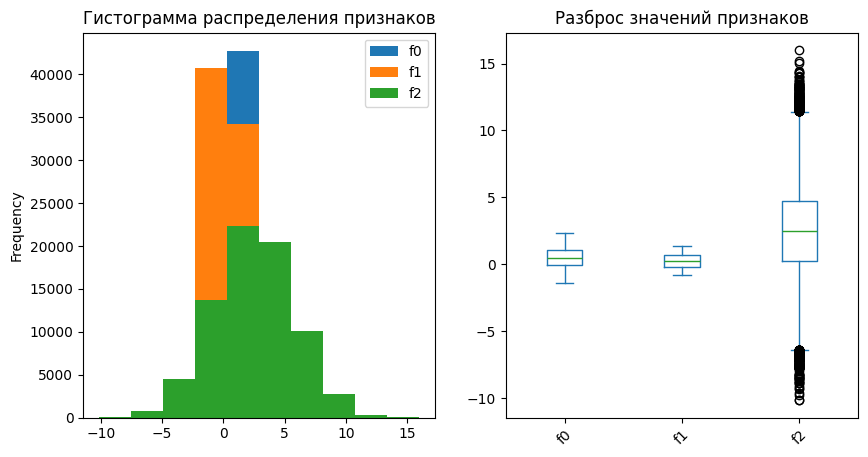


Датафрейм df_geo_0 — остатки модели:


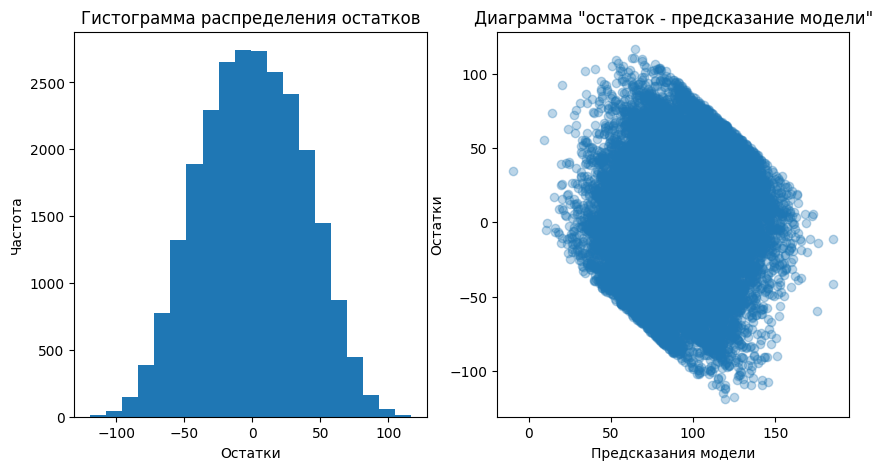


Метрики для датафрейма df_geo_0:
R2: 0.27
RMSE: 37.69
MAE: 31.03
Residuals mean: -0.22
Residuals std: 37.69


In [23]:
#df_geo_0
num_columns = ['f0','f1','f2']
product_pred_geo_0 = product_prediction(df_geo_0, num_columns, 'df_geo_0')

Значение метрики RMSE достаточно высокое - 37.69. Остатки распределены нормально вокруг 0, однако распределение остатков в зависимости от предсказанного значения неравномерно. Максимальные по модулю значения остатков находятся в интервале от 50 до 150 предсказанных значений целевого признака и достигают по модулю 120, минимальные значения остатка наблюдаются для предсказанных значений целевого признака от 0 до 50 и выше 150.

Посмотрим, как будет менятся метрика при изменения набора входных признаков:

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели по кросс-валидации (neg RMSE): -38.23399404770202

Датафрейм df_geo_0 — распределение признаков:


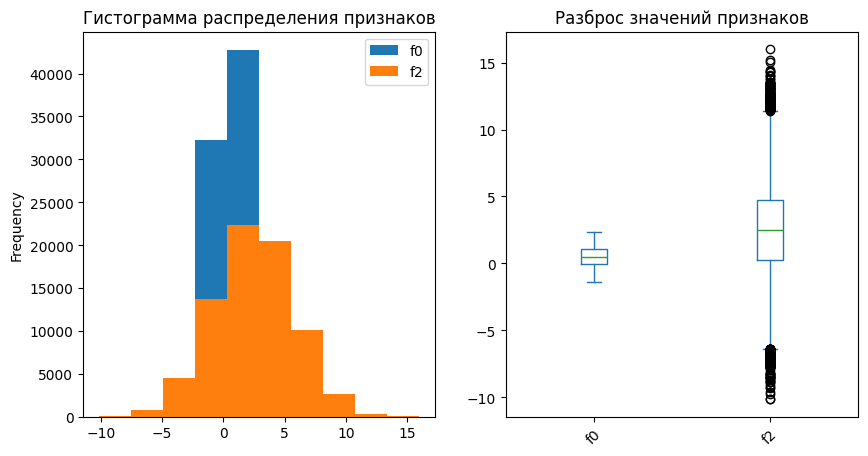


Датафрейм df_geo_0 — остатки модели:


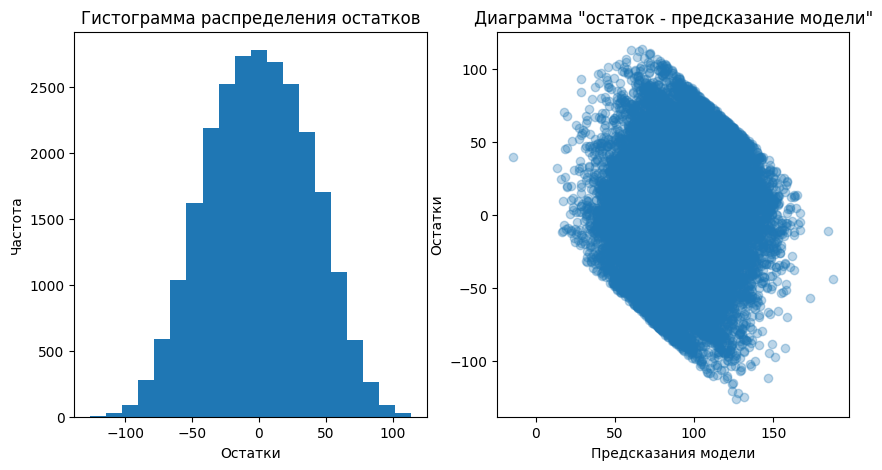


Метрики для датафрейма df_geo_0:
R2: 0.25
RMSE: 38.21
MAE: 31.41
Residuals mean: -0.16
Residuals std: 38.21
Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели по кросс-валидации (neg RMSE): -37.805492147587984

Датафрейм df_geo_0 — распределение признаков:


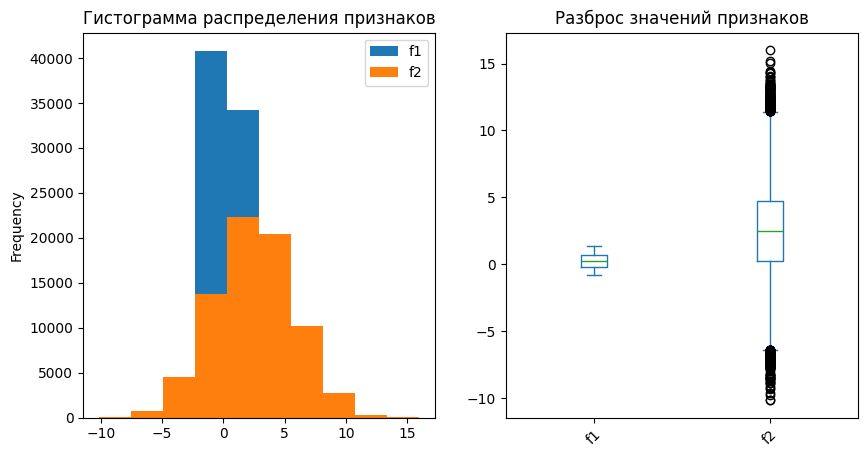


Датафрейм df_geo_0 — остатки модели:


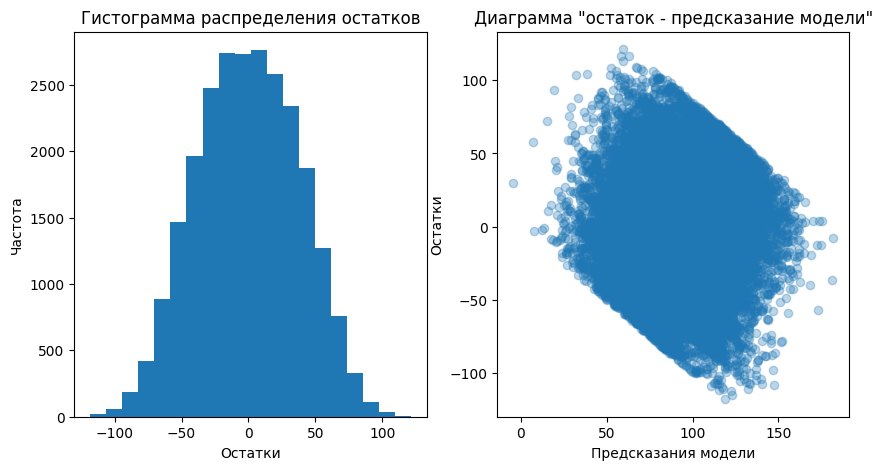


Метрики для датафрейма df_geo_0:
R2: 0.27
RMSE: 37.82
MAE: 31.14
Residuals mean: -0.26
Residuals std: 37.82
Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1'])])),
                ('models', LinearRegression())])
Метрика лучшей модели по кросс-валидации (neg RMSE): -43.36461183309073

Датафрейм df_geo_0 — распределение признаков:


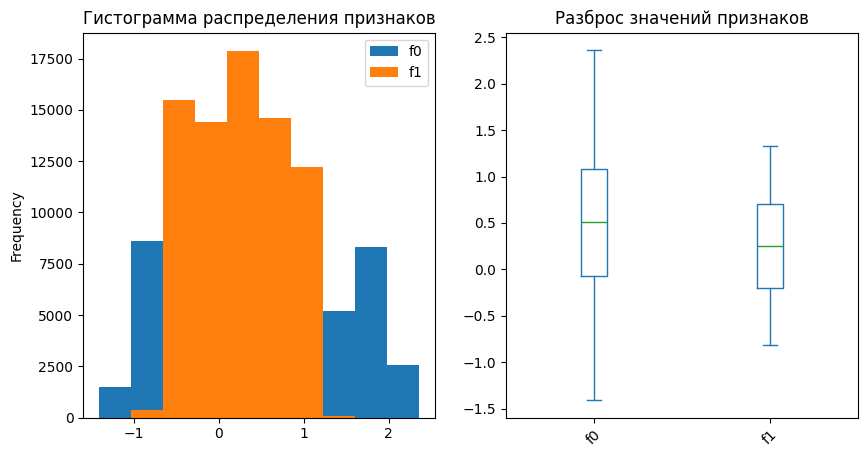


Датафрейм df_geo_0 — остатки модели:


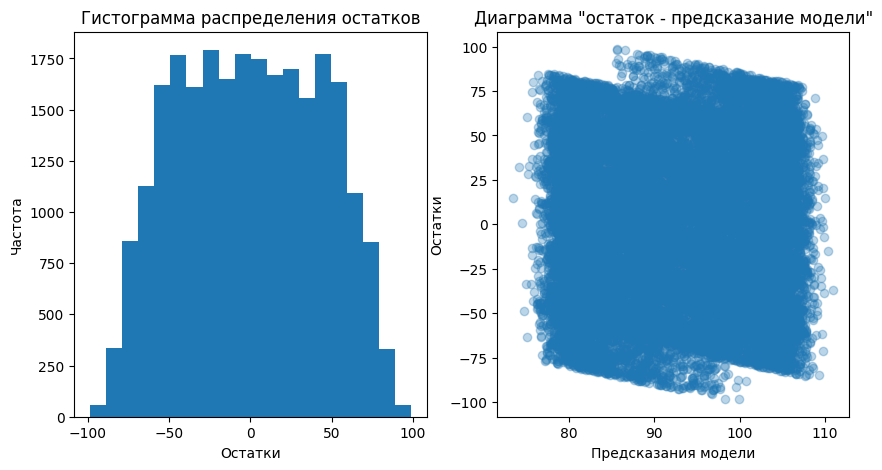


Метрики для датафрейма df_geo_0:
R2: 0.04
RMSE: 43.37
MAE: 37.06
Residuals mean: -0.15
Residuals std: 43.37
Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели по кросс-валидации (neg RMSE): -38.75713594762792

Датафрейм df_geo_0 — распределение признаков:


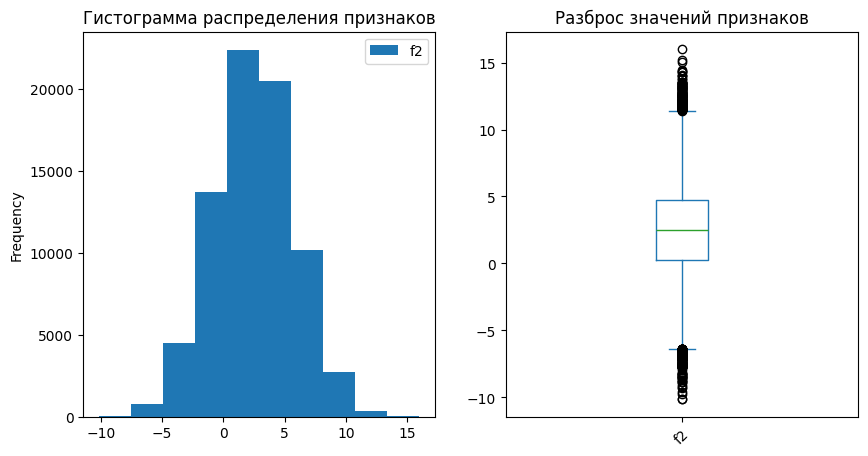


Датафрейм df_geo_0 — остатки модели:


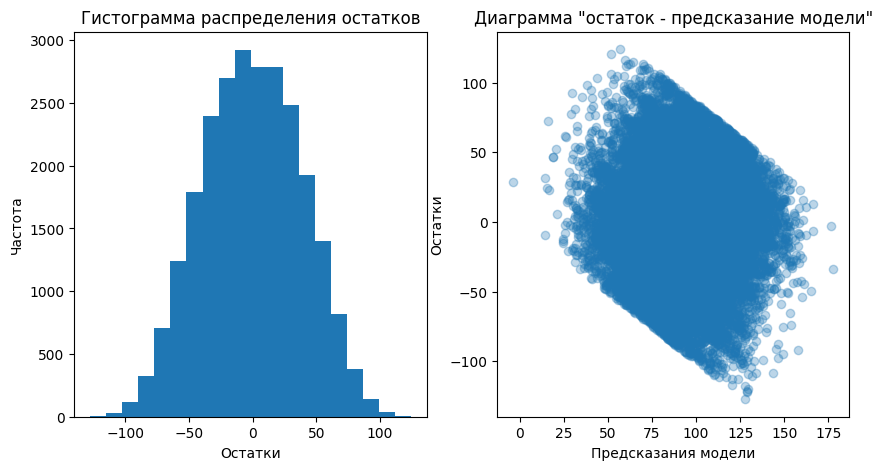


Метрики для датафрейма df_geo_0:
R2: 0.23
RMSE: 38.78
MAE: 31.85
Residuals mean: -0.22
Residuals std: 38.78


In [24]:
for num_columns in [['f0','f2'], ['f1','f2'],['f0','f1'], ['f2']]:
    product_prediction(df_geo_0, num_columns, 'df_geo_0')

Таким образом, при использовании всех входных признаков для обучения модели получаем лучший результат - RMSE=37.69, R2=0.27.

In [25]:
#Среднее значение предсказанного product
print(
    "Средний предсказанный объем запасов в скважине (df_geo_0):",
    product_pred_geo_0[1]['product_pred'].mean().round(2)
)
print("RMSE модели предсказания (df_geo_0):", product_pred_geo_0[4])

Средний предсказанный объем запасов в скважине (df_geo_0): 92.61
RMSE модели предсказания (df_geo_0): 37.69


### Обучение модели на df_geo_1

Целевой признак product и входной признак f2 имеют коэффииент корреляции ~1, что может ворить об утечке целевого признака. При этом с f0 и f1 целевой признак product не имеет линейной зависимости. Обучим модель со следующими комбинациями входных признаков:  
- f0, f1, f2
- f0, f1
- f2



ОБУЧЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ СО ВХОДНЫМИ ПРИЗНАКАМИ ['f0', 'f1', 'f2']


Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели по кросс-валидации (neg RMSE): -0.8896094467301927

Датафрейм df_geo_1 — распределение признаков:


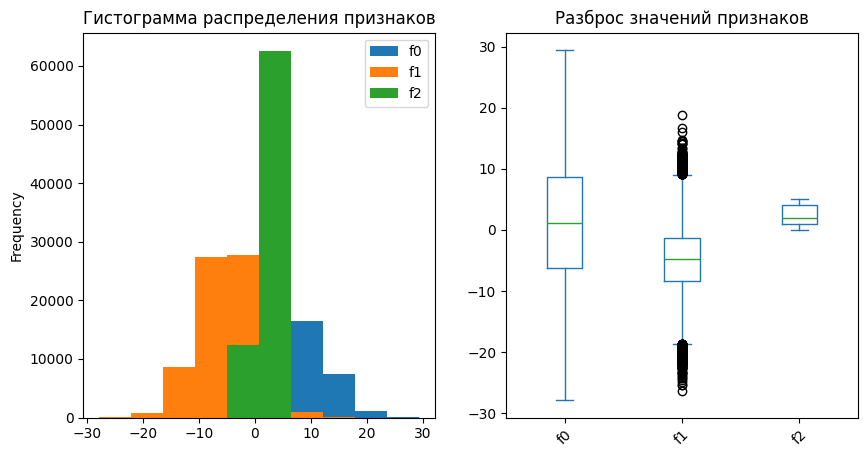


Датафрейм df_geo_1 — остатки модели:


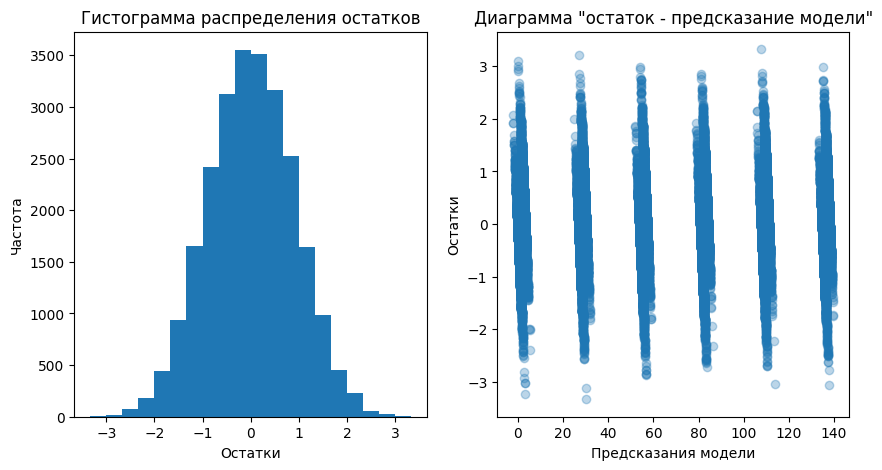


Метрики для датафрейма df_geo_1:
R2: 1.0
RMSE: 0.89
MAE: 0.72
Residuals mean: 0.01
Residuals std: 0.89


ОБУЧЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ СО ВХОДНЫМИ ПРИЗНАКАМИ ['f0', 'f1']


Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1'])])),
                ('models', LinearRegression())])
Метрика лучшей модели по кросс-валидации (neg RMSE): -45.91803989850115

Датафрейм df_geo_1 — распределение признаков:


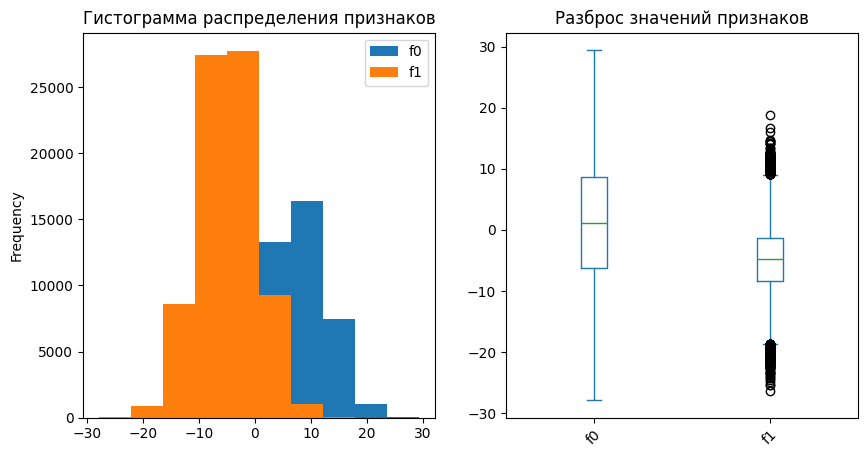


Датафрейм df_geo_1 — остатки модели:


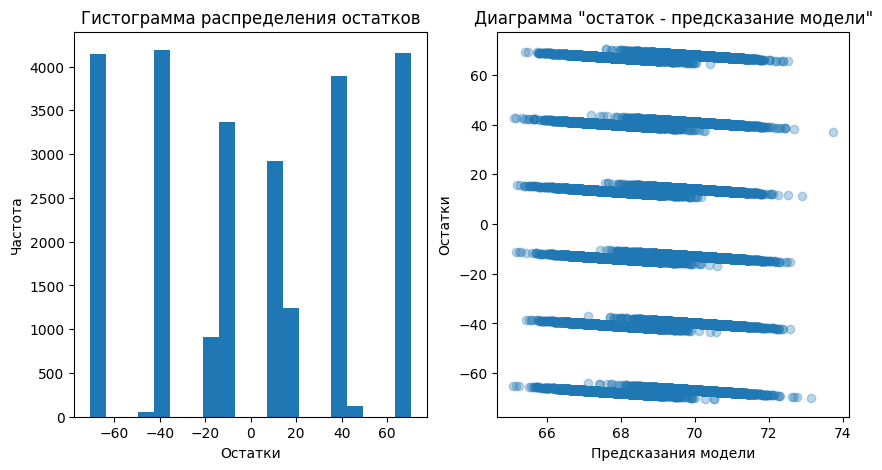


Метрики для датафрейма df_geo_1:
R2: 0.0
RMSE: 45.94
MAE: 40.29
Residuals mean: -0.33
Residuals std: 45.94


ОБУЧЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ СО ВХОДНЫМИ ПРИЗНАКАМИ ['f2']


Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели по кросс-валидации (neg RMSE): -1.5953435970235434

Датафрейм df_geo_1 — распределение признаков:


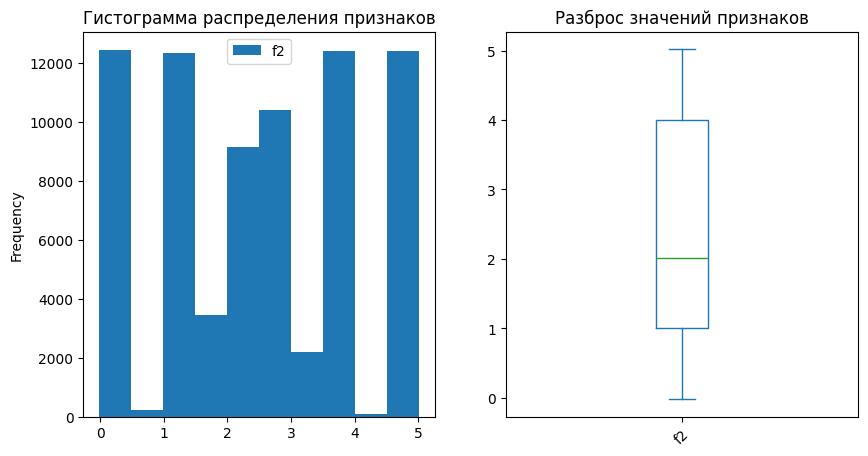


Датафрейм df_geo_1 — остатки модели:


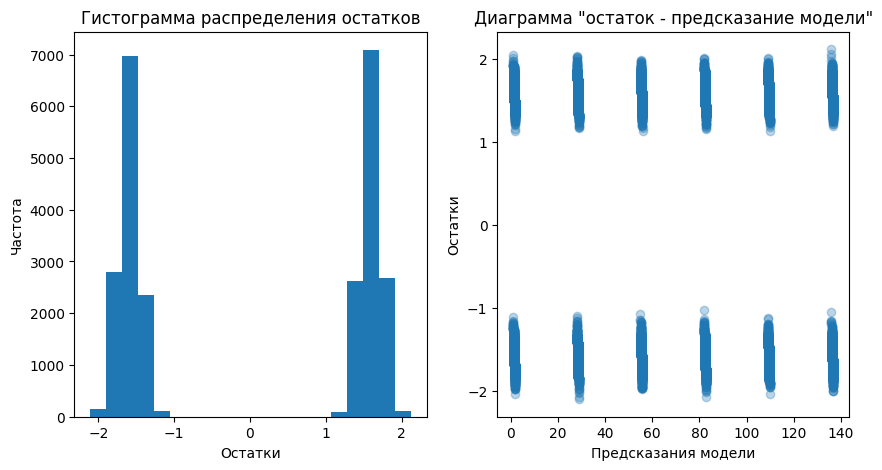


Метрики для датафрейма df_geo_1:
R2: 1.0
RMSE: 1.6
MAE: 1.59
Residuals mean: 0.02
Residuals std: 1.6


In [26]:
#df_geo_1
for num_columns in [['f0','f1','f2'], ['f0','f1'],['f2']]:
    print(f'\n\nОБУЧЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ СО ВХОДНЫМИ ПРИЗНАКАМИ {num_columns}\n\n')
    product_prediction(df_geo_1, num_columns, 'df_geo_1')

Таким образом, лучшие значения метрик получаются при использовании всего набора входных признаков. В таком случае RMSE=0.88, R2=1. Среднее значчение остатков равно 0, стандартное отклонение равно 0.89.

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели по кросс-валидации (neg RMSE): -0.8896094467301927

Датафрейм df_geo_1 — распределение признаков:


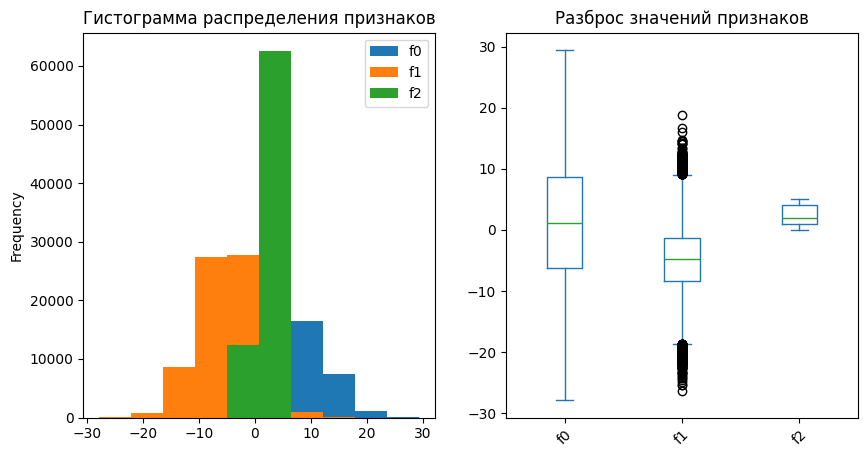


Датафрейм df_geo_1 — остатки модели:


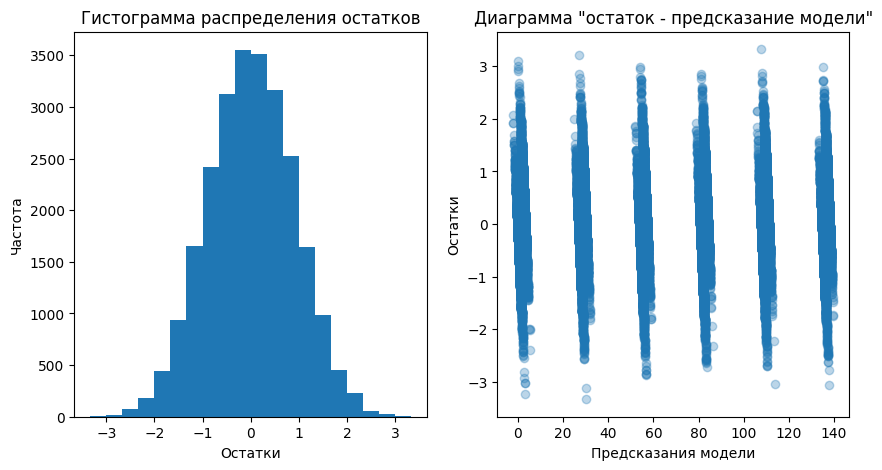


Метрики для датафрейма df_geo_1:
R2: 1.0
RMSE: 0.89
MAE: 0.72
Residuals mean: 0.01
Residuals std: 0.89


In [27]:
#df_geo_1
num_columns = ['f0','f1','f2']
product_pred_geo_1 = product_prediction(df_geo_1, num_columns, 'df_geo_1')

In [28]:
#Среднее значение предсказанного product
print(
    "Средний предсказанный объем запасов в скважине (df_geo_1):",
    product_pred_geo_1[1]['product_pred'].mean().round(2)
)
print("RMSE модели предсказания (df_geo_1):", product_pred_geo_1[4])

Средний предсказанный объем запасов в скважине (df_geo_1): 68.58
RMSE модели предсказания (df_geo_1): 0.89


### Обучение модели на df_geo_2

Целевой признак product и входной признак f2 имеют слабую линейную зависимость, при этом с f0 и f1 целевой признак product не имеет линейной зависимости. Обучим модель со следующими комбинациями входных признаков:  
- f0, f1, f2
- f0, f1
- f2



ОБУЧЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ СО ВХОДНЫМИ ПРИЗНАКАМИ ['f0', 'f1', 'f2']


Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели по кросс-валидации (neg RMSE): -40.04773914637898

Датафрейм df_geo_2 — распределение признаков:


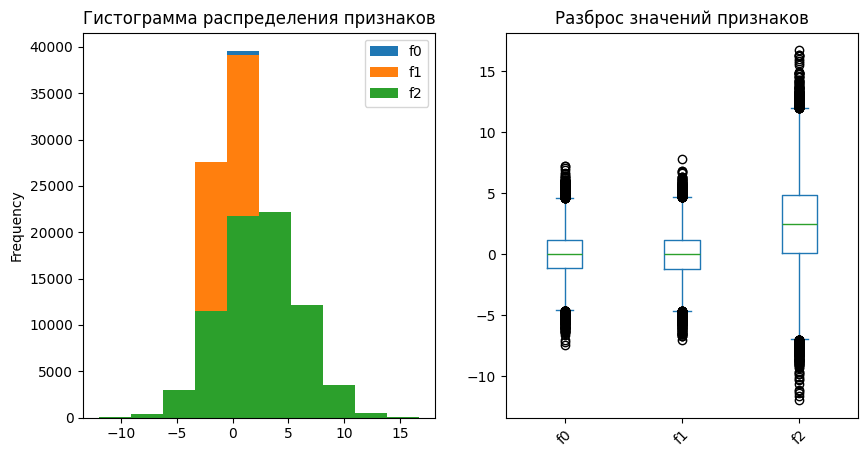


Датафрейм df_geo_2 — остатки модели:


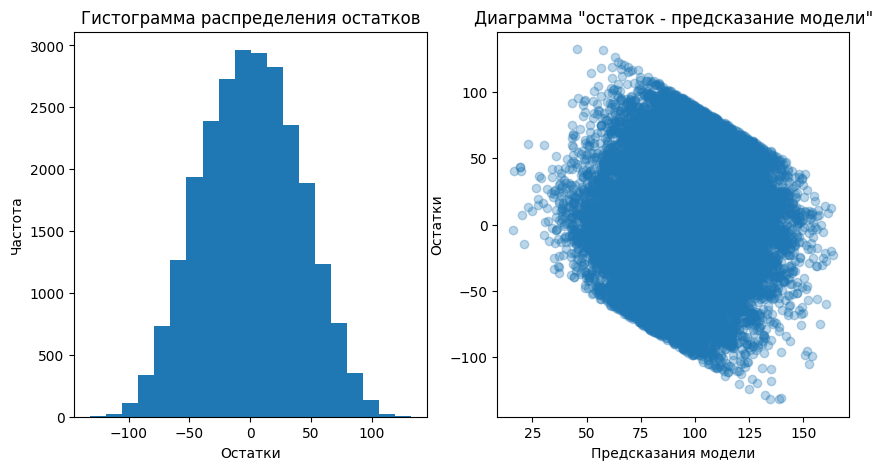


Метрики для датафрейма df_geo_2:
R2: 0.19
RMSE: 40.08
MAE: 32.84
Residuals mean: 0.32
Residuals std: 40.08


ОБУЧЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ СО ВХОДНЫМИ ПРИЗНАКАМИ ['f0', 'f1']


Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1'])])),
                ('models', LinearRegression())])
Метрика лучшей модели по кросс-валидации (neg RMSE): -44.77710077497429

Датафрейм df_geo_2 — распределение признаков:


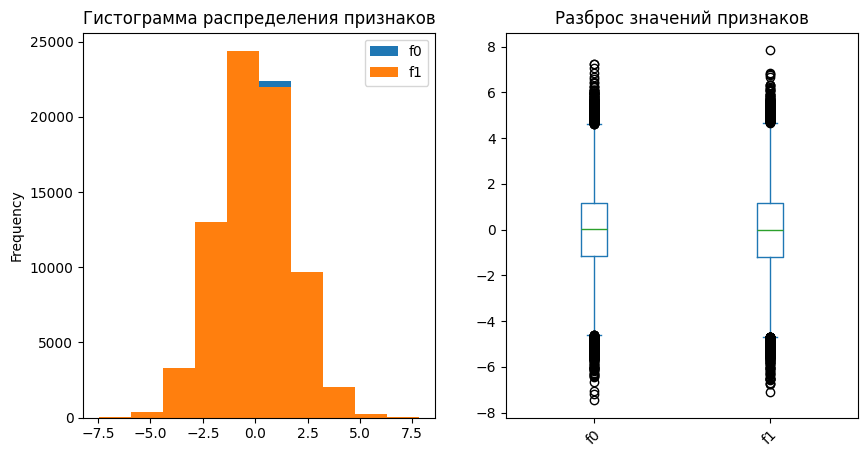


Датафрейм df_geo_2 — остатки модели:


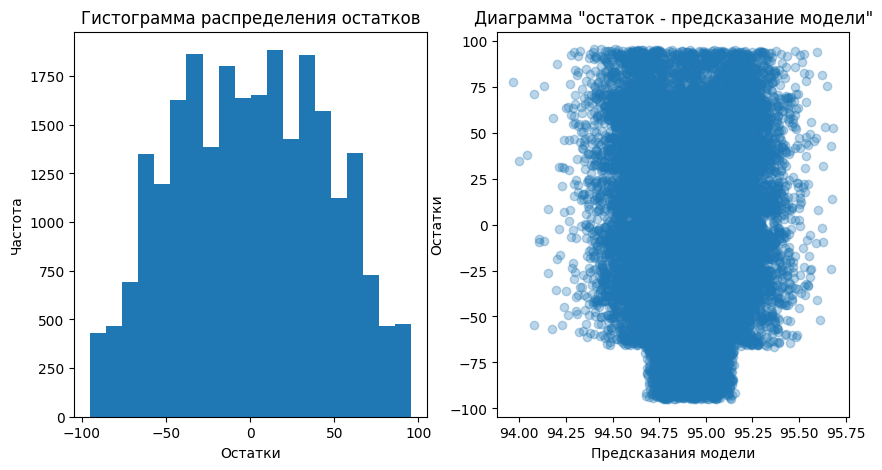


Метрики для датафрейма df_geo_2:
R2: -0.0
RMSE: 44.67
MAE: 37.73
Residuals mean: 0.34
Residuals std: 44.67


ОБУЧЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ СО ВХОДНЫМИ ПРИЗНАКАМИ ['f2']


Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели по кросс-валидации (neg RMSE): -40.04700782826101

Датафрейм df_geo_2 — распределение признаков:


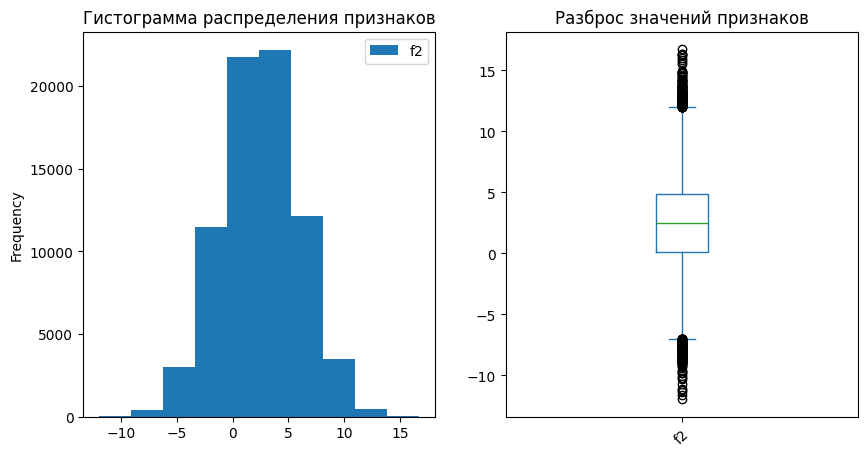


Датафрейм df_geo_2 — остатки модели:


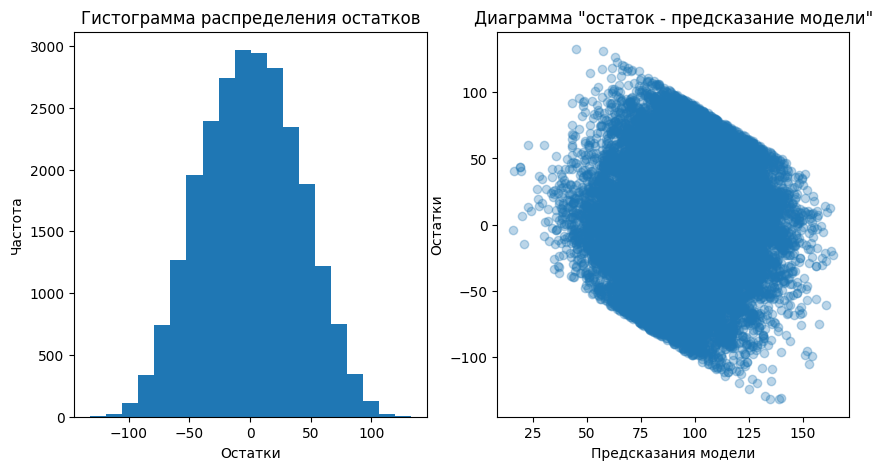


Метрики для датафрейма df_geo_2:
R2: 0.19
RMSE: 40.08
MAE: 32.84
Residuals mean: 0.32
Residuals std: 40.08


In [29]:
#df_geo_2
for num_columns in [['f0','f1','f2'], ['f0','f1'],['f2']]:
    print(f'\n\nОБУЧЕНИЕ ЛИНЕЙНОЙ МОДЕЛИ СО ВХОДНЫМИ ПРИЗНАКАМИ {num_columns}\n\n')
    product_prediction(df_geo_2, num_columns, 'df_geo_2')

Таким образом, метрики R2 и RMSE имеют одинаковые значения для комбинаций входных признаков [f0, f1, f2] и ['f2'], равные, соответственно, 0.19 и 40.08. Среднее значение остатков - 0.32. Максимальные по модулю значения остатков находятся в интервале от 50 до 150 предсказанных значений целевого признака и достигают по модулю 120, минимальные значения остатка наблюдаются для предсказанных значений целевого признака от 0 до 50 и выше 150.

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели по кросс-валидации (neg RMSE): -40.04773914637898

Датафрейм df_geo_2 — распределение признаков:


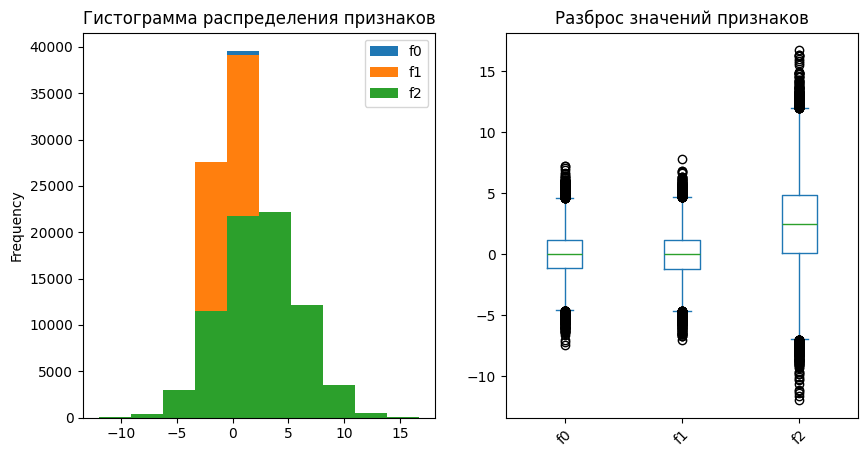


Датафрейм df_geo_2 — остатки модели:


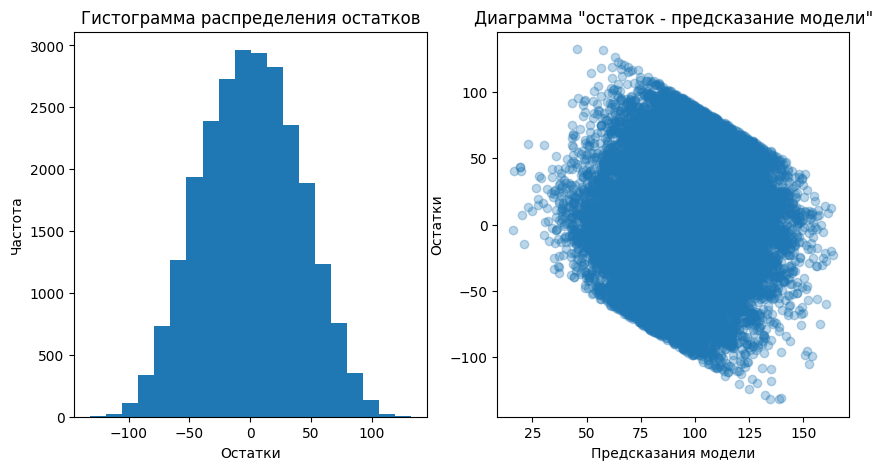


Метрики для датафрейма df_geo_2:
R2: 0.19
RMSE: 40.08
MAE: 32.84
Residuals mean: 0.32
Residuals std: 40.08


In [30]:
#df_geo_2
num_columns = ['f0','f1','f2']
product_pred_geo_2 = product_prediction(df_geo_2, num_columns, 'df_geo_2')

In [31]:
#Среднее значение предсказанного product
print(
    "Средний предсказанный объем запасов в скважине (df_geo_2):",
    product_pred_geo_2[1]['product_pred'].mean().round(2)
)
print("RMSE модели предсказания (df_geo_2):", product_pred_geo_2[4])

Средний предсказанный объем запасов в скважине (df_geo_2): 94.93
RMSE модели предсказания (df_geo_2): 40.08


### Выводы по обучению модели

Для каждого региона были предсказаны объемы запасы в скважинах с помощью линейной регрессии.  
Для региона geo_0 получено среднее занчение запасов в скважине, равное 92.6, RMSE модели предсказания равно 37.7  
Для региона geo_1 получено среднее занчение запасов в скважине, равное 68.6, RMSE модели предсказания равно 0.89  
Для региона geo_2 получено среднее занчение запасов в скважине, равное 94.93, RMSE модели предсказания равно 40.5 

Низкое значение RMSE для geo_1 обусловлено наличием входного признака f2, коэффициент корреляции целевого признака с которым равен 0.98, что может являться утечкой целевого признака, однако, на других площадях такой корреляции не наблюдается.

## Подготовка к расчёту прибыли

In [32]:
# Бюджет на регион
budget = 10_000_000_000
# Количество скважин для разработки
well_num = 200
# Цена нефти
oil_price = 450
# Бюджет на разработку одной скважины
budget_per_well = budget/well_num

In [33]:
budget_per_well

50000000.0

In [34]:
# Рассчитаем минимальный запас сырья для безубыточной разработки
min_necessary_product = budget_per_well / (450 * 1000)

In [35]:
min_necessary_product

111.11111111111111

Значения минимального запаса сырья для безубыточной разработки скважины выше, чем средние значения запасов по каждой площади, равные, соответственно, 92.6, 68.6, 94.9

## Расчёт прибыли и рисков с помощью методики Bootstrap

Напишем функцию, которая будет рассчитывать прибыль:

In [36]:
# Функция для расчета прибыли
def profit_calc(df,  top_num, oil_price, budget_per_well):
    selected = df.sort_values(by='product_pred', ascending=False)['product'].head(top_num)
    
    profit = selected.sum() * (oil_price*1000) - budget_per_well * len(selected)
    return profit

Реализуем Bootstrap:

In [37]:
# Bootstrap для geo_0
state = np.random.RandomState(12345)

# Колчество скважин в выборке
well_num_subsample = 500

df = product_pred_geo_0[1]


values = []
for i in range(1000):
    df_subsample = df.sample(well_num_subsample, replace=True, random_state=state)
    values.append(profit_calc(df_subsample, well_num, oil_price,budget_per_well))

In [38]:
# Датафрейм для хранения прибыли для каждой площади
profit_table = pd.DataFrame({'profits_geo_0': values})

In [39]:
# Bootstrap для geo_1
df = product_pred_geo_1[1]

values = []
for i in range(1000):
    df_subsample = df.sample(well_num_subsample, replace=True, random_state=state)
    values.append(profit_calc(df_subsample, well_num, oil_price,budget_per_well))
    
# Добавим прибыль в колонку profits_geo_1 таблицы profit_table
profit_table['profits_geo_1'] = values

In [40]:
# Bootstrap для geo_2

df = product_pred_geo_2[1]

values = []
for i in range(1000):
    df_subsample = df.sample(well_num_subsample, replace=True, random_state=state)
    values.append(profit_calc(df_subsample, well_num, oil_price,budget_per_well))
    
# Добавим прибыль в колонку profits_geo_2 таблицы profit_table
profit_table['profits_geo_2'] = values

In [41]:
profit_table.head()

profits_geo_0  profits_geo_1  profits_geo_2
0   4.684954e+08   5.761486e+08   3.554381e+08
1   3.587123e+08   5.833016e+08   6.421055e+08
2   3.840758e+08   3.657266e+08   1.959966e+08
3   1.496328e+08   3.707026e+08   6.607268e+08
4   7.289494e+08   9.671232e+07   4.905926e+08

Статистика по датафрейму profit_table


count          mean           std           min           25%  \
profits_geo_0  1000.0  4.173544e+08  2.694371e+08 -5.287278e+08  2.323979e+08   
profits_geo_1  1000.0  4.354397e+08  2.040239e+08 -2.407840e+08  3.034646e+08   
profits_geo_2  1000.0  3.558747e+08  2.771977e+08 -6.474508e+08  1.792246e+08   

                        50%           75%           max  
profits_geo_0  4.320130e+08  5.967520e+08  1.363068e+09  
profits_geo_1  4.352660e+08  5.761486e+08  1.136942e+09  
profits_geo_2  3.540420e+08  5.505496e+08  1.183864e+09

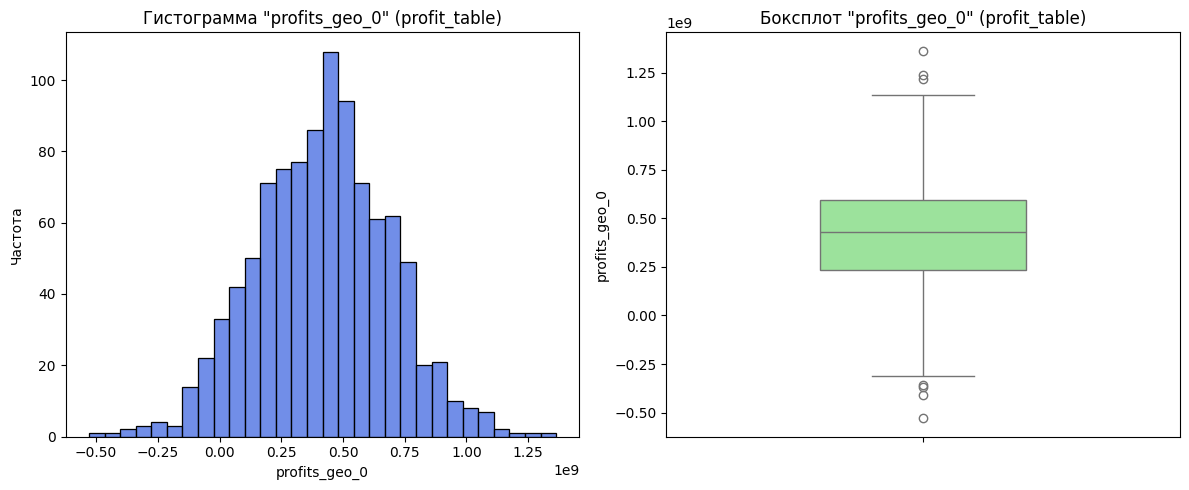

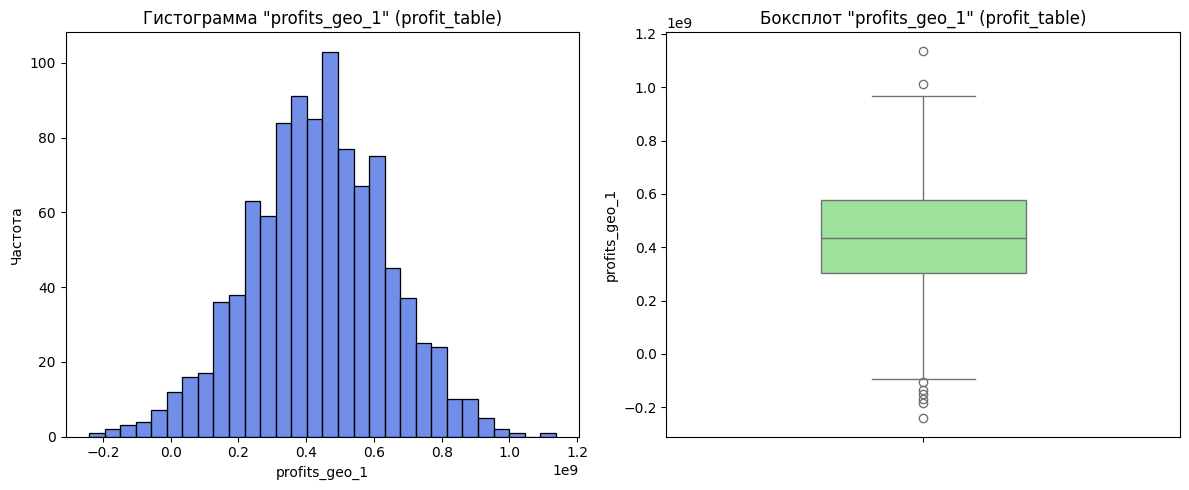

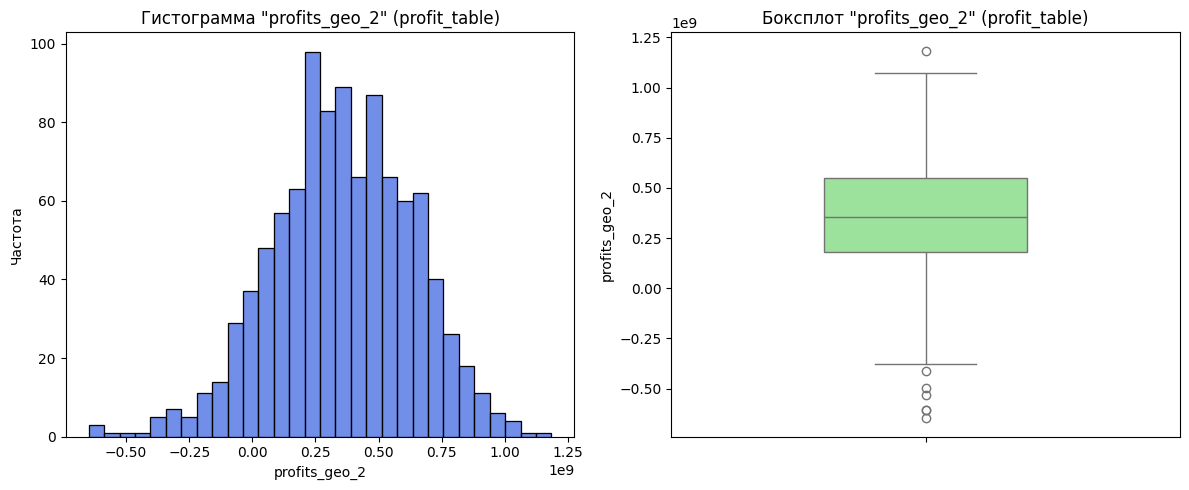

In [42]:
stat_hist_boxplot_builder(profit_table, profit_table.columns, 'profit_table')

Средние прибыли для площадей равны:  
    geo_0: 417 млн. рублей  
    geo_1: 435 млн. рублей  
    geo_1: 356 млн. рублей  

Посчитаем вероятность убытков для каждой площади:

In [43]:
#geo_0
loss_prob_geo_0 = (profit_table['profits_geo_0'] < 0).mean() * 100
print('Вероятность убытка для площади geo_0:',loss_prob_geo_0,'%')

Вероятность убытка для площади geo_0: 5.8999999999999995 %


In [44]:
#geo_1
loss_prob_geo_1 = (profit_table['profits_geo_1'] < 0).mean() * 100
print('Вероятность убытка для площади geo_1:',loss_prob_geo_1,'%')

Вероятность убытка для площади geo_1: 1.9 %


In [45]:
#geo_2
loss_prob_geo_2 = (profit_table['profits_geo_2'] < 0).mean() * 100
print('Вероятность убытка для площади geo_2:',loss_prob_geo_2,'%')

Вероятность убытка для площади geo_2: 9.8 %


Таким образом, вероятность убытка менее 2.5 % достигается только для площади geo_1 (вероятность убытка 1.9 %), за счет более точного предсказания запасов нефти моделью. 

#### Выводы по расчету прибыли и рисков

Средние прибыли для площадей равны:  
    geo_0: 417 млн. рублей  
    geo_1: 435 млн. рублей  
    geo_1: 356 млн. рублей  
        
Вероятности убытка для площадей равны:  
    geo_0: 5.9 %  
    geo_1: 1.9 %  
    geo_1: 9.8 %
        
Таким образом, вероятность убытка менее 2.5 % достигается только для площади geo_1 (вероятность убытка 1.9 %) за счет более точного предсказания запасов нефти моделью.  

## Общие выводы

Были загружены данные по площадям geo_0, geo_1, geo_2. Была выолнена предобработка данных, исследовательский и корреляционный анализ. Для каждой площади было выполнено обучение линейной модели предсказания запасов нефти.  
Получены следующие результаты по обучению моделей:  
- для региона geo_0 получено среднее занчение запасов в скважине, равное 92.6, RMSE модели предсказания равно 37.7  
- для региона geo_1 получено среднее занчение запасов в скважине, равное 68.6, RMSE модели предсказания равно 0.89  
- для региона geo_2 получено среднее занчение запасов в скважине, равное 94.93, RMSE модели предсказания равно 40.5   
Низкое значение RMSE для geo_1 обусловлено наличием входного признака f2, коэффициент корреляции целевого признака с которым равен 0.98, что может являться утечкой целевого признака, однако, на других площадях такой корреляции не наблюдается.

С помощью Bootstrap были рассчитаны прибыль и вероятность рисков. Были получены следующие результаты:  

Средние прибыли для площадей равны:  
    geo_0: 417 млн. рублей  
    geo_1: 435 млн. рублей  
    geo_1: 356 млн. рублей    
        
Вероятности убытка для площадей равны:  
    geo_0: 5.9 %  
    geo_1: 1.9 %  
    geo_1: 9.8 %

Таким образом, вероятность убытка менее 2.5 % достигается только для площади geo_1 (вероятность убытка 1 %) за счет более точного предсказания запасов нефти моделью. Данная площадь рекомендуется к разаботке.